In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix,accuracy_score
import json
from sklearn.ensemble import RandomForestClassifier
import operator
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [2]:
from functions.preprocessing import *
from functions.functions import *
from functions.df_modifications import *
from functions.feature_selection import *
from functions.other import *

In [3]:
type_of_df = 'vl'
type_of_mask = 'v1'

In [10]:
df = pd.read_csv(f'data/TG_{type_of_df}.csv', index_col = 0)
df.columns = [col.replace('__gen', '') for col in df.columns]
df.index = [ind.replace('_pat','').replace('_non','') for ind in df.index]
df['id'] = df.index.map(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
df1 = df.copy()
df.head()

,pathology,f_1_1_10__left__v1,f_1_1_10__right__v1,f_1_1_10__v1,f_1_1_1__left__v1,f_1_1_1__right__v1,f_1_1_1__v1,f_1_1_2__left__v1,f_1_1_2__right__v1,f_1_1_2__v1,...,f_4_5_4__v1__(bw_3)__2_3,f_4_5_4__v1__(bw_3)__2_4,f_4_5_4__v1__(bw_3)__2_5,f_4_5_4__v1__(bw_3)__3_0,f_4_5_4__v1__(bw_3)__3_1,f_4_5_4__v1__(bw_3)__3_2,f_4_5_4__v1__(bw_3)__3_3,f_4_5_4__v1__(bw_3)__3_4,f_4_5_4__v1__(bw_3)__3_5,id
PAC_00_DN0_RAW,1,153.0,153.0,152.0,128.465223,128.465223,127.877683,19.200861,19.200861,19.067926,...,122.665680,127.715976,126.991124,45.464497,43.905325,44.529586,45.517751,44.529586,43.905325,PAC_00
PAC_00_DN10_RAW,1,173.0,173.0,173.0,145.996855,145.996855,145.996855,20.726065,20.726065,20.726065,...,101.460000,113.042857,114.534286,24.182857,23.397143,23.517143,22.822857,23.517143,23.397143,PAC_00
PAC_00_DN11_RAW,1,171.0,171.0,171.0,144.972555,144.972555,144.972555,19.626635,19.626635,19.626635,...,103.038690,111.217262,112.517857,24.818452,21.264881,21.199405,24.181548,21.199405,21.264881,PAC_00
PAC_00_DN12_RAW,1,173.0,173.0,173.0,146.945692,146.945692,146.809036,20.425921,20.425921,20.360977,...,90.267442,100.476744,98.279070,19.351744,18.104651,17.715116,20.043605,17.715116,18.104651,PAC_00
PAC_00_DN13_RAW,1,176.0,176.0,176.0,148.365707,148.365707,148.365707,20.948782,20.948782,20.948782,...,96.054755,106.556196,106.340058,18.501441,16.253602,16.389049,19.242075,16.389049,16.253602,PAC_00


In [11]:
df = df1.copy()
df_non_symm = df[(df.f_1_1_1__right__v1 != df.f_1_1_1__left__v1) | (df.pathology == 0)]
df_symm = df[(df.f_1_1_1__right__v1 == df.f_1_1_1__v1).values & (df.f_1_1_1__left__v1 == df.f_1_1_1__v1).values]

df_non_symm = split_areas(df_non_symm)
df_symm = split_areas(df_symm)
df_symm = df_symm.loc[[ind for ind in df_symm.index if ind.find('right') != -1], :]

df = pd.concat([df_symm,df_non_symm],axis=0)
df1 = df.copy()

In [12]:
test_id = ['PAC_69','PAC_48','PAC_14','PAC_65','PAC_63','PAC_66','PAC_61','PAC_64','PAC_62']
#df = df[[col for col in df.columns if col.find('f_1') != -1 or col.find('f_4') != -1 ] + ['id', 'pathology']]
df_test = df[df.id.isin(test_id)]
df = df.drop(df_test.index)
df1 = df.copy()

In [13]:
y = df.pathology
X = df.iloc[:,:-2]
id_column = df.id

y_control = df_test.pathology
X_control = df_test.iloc[:,:-2]
X1 = X.copy()

#cols = [col for col in X.columns if col.find('f_3') == -1 and col.find('f_2') == -1]

#X = X[cols]
#X_control = X_control[cols]

In [14]:
def first_round(X_train, X_test, X_control):
    X_train,q1 = variance(X_train)
    X_train,q2 = outliers(X_train)
    X_train = correlation(X_train, thr=0.95)
    return X_train, X_test[X_train.columns], X_control[X_train.columns]


second_round = [ttest, pca, permut, lr_selection, boruta_selection, greedy]

In [23]:
X_control_main = X_control.copy()

In [ ]:
n=5
N=5

res = {}
for s in range(N):
    res[f'split_{s}'] = {}
    for func in second_round:
        res[f'split_{s}'][func.__name__] = {}
        for model_name in ['lr', 'svm', 'rf', 'xgb']:
            res[f'split_{s}'][func.__name__][model_name] = {}
            for metric in ['acc_test', 'auc_test', 'acc_control', 'auc_control']:
                res[f'split_{s}'][func.__name__][model_name][metric] = []
        res[f'split_{s}'][func.__name__]['n_features'] = []

for s in tqdm(range(N)):   
    X_fold, y_fold = make_folds(X,y,n=n, id_column=id_column)
    for j in tqdm(range(n)):
        X_control = X_control_main.copy()
        X_train, y_train = pd.concat([X_fold[k] for k in range(len(X_fold)) if k!=j]),pd.concat([y_fold[k] for k in range(len(X_fold)) if k!=j])
        X_test,y_test = X_fold[j].copy(), y_fold[j].copy()    

        X_train, X_test, X_control = first_round(X_train, X_test, X_control)

        print(f'FOLD {j}')
        print(f'First round selection: {X_train.columns.size} features')

        for func in second_round:
            X_train_c = X_train.copy()
            X_test_c = X_test.copy()
            X_control_c = X_control.copy()
            #kwargs = {'id_column': id_column}
            try:
                X_train, X_test, X_control = func(X_train, y_train,X_test, y_test, X_control)
                print(f'Second round selection: {X_train.columns.size} features ({func.__name__})')
                res[f'split_{s}'][func.__name__]['n_features'].append(X_train.columns.size)
            except:
                for model_name in ['lr', 'svm', 'rf', 'xgb']:
                    res = write_dict(res, f'split_{s}', func.__name__, model_name, y_test, X_test, 
                                     y_control, X_control, None, fillna=True)
                    res[f'split_{s}'][func.__name__]['n_features'].append(float('nan'))
                continue

            for model_name in ['lr', 'svm', 'rf', 'xgb']:
                try:
                    if model_name == 'svm':
                        dict_concat = {'probability':True}
                        X_train_non = X_train.copy()
                        X_test_non = X_test.copy()
                        X_control_non = X_control.copy()
                        X_train, y_train, X_test, y_test, scaler = normalization(X_train, y_train, X_test, y_test)
                        X_control.loc[:, :] = scaler.transform(X_control)
                    else:
                        dict_concat = {}
                    print(model_name)

                    clf = hp_model(model_name, X_train, y_train, evals=15, max_iterations=51,metric=roc_auc_score, 
                                  dict_concat=dict_concat, id_column=id_column, oversampling=False, random_state=42, 
                                  class_w='balanced', n_folds=5, thr_diff=0.2, thr_min=0.6, print_scores=False)
                    res = write_dict(res, f'split_{s}', func.__name__, model_name, y_test, X_test, 
                                     y_control, X_control, clf, fillna=False)
                    X_train, X_test, X_control =  X_train_non.copy(), X_test_non.copy(), X_control_non.copy()
                except:
                    res = write_dict(res, f'split_{s}', func.__name__, model_name, y_test, X_test, 
                                     y_control, X_control, None, fillna=True)
                    continue
                
                with open('results.json', 'w+') as f:
                    json.dump(res, f)
                X_train, X_test, X_control = X_train_c.copy(), X_test_c.copy(), X_control_c.copy() 


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

FOLD 0
First round selection: 178 features
Second round selection: 22 features (lr_selection)
lr
split_0 lr_selection lr NaN FILLING
svm
rf
xgb
FOLD 1
First round selection: 180 features
Second round selection: 20 features (lr_selection)
lr
svm
rf
xgb
FOLD 2
First round selection: 182 features
Second round selection: 27 features (lr_selection)
lr
svm
rf
xgb
FOLD 3
First round selection: 184 features
Second round selection: 26 features (lr_selection)
lr
svm
rf
xgb
FOLD 4
First round selection: 184 features
Second round selection: 27 features (lr_selection)
lr
svm
rf
xgb


  0%|          | 0/5 [00:00<?, ?it/s]

FOLD 0
First round selection: 182 features
Second round selection: 23 features (lr_selection)
lr
svm
rf
xgb
FOLD 1
First round selection: 177 features
Second round selection: 24 features (lr_selection)
lr
svm
rf
xgb
FOLD 2
First round selection: 182 features
Second round selection: 29 features (lr_selection)
lr
svm
rf
xgb
FOLD 3
First round selection: 181 features
Second round selection: 26 features (lr_selection)
lr
svm
rf
xgb
FOLD 4
First round selection: 190 features
Second round selection: 20 features (lr_selection)
lr
svm
rf
xgb


  0%|          | 0/5 [00:00<?, ?it/s]

FOLD 0
First round selection: 180 features
Second round selection: 25 features (lr_selection)
lr
svm
rf
xgb
FOLD 1
First round selection: 183 features
Second round selection: 20 features (lr_selection)
lr
svm
rf
xgb
FOLD 2
First round selection: 179 features
Second round selection: 20 features (lr_selection)
lr
svm
rf
xgb
FOLD 3
First round selection: 181 features
Second round selection: 32 features (lr_selection)
lr
svm
rf
xgb
FOLD 4
First round selection: 181 features
Second round selection: 24 features (lr_selection)
lr
svm
rf
xgb


  0%|          | 0/5 [00:00<?, ?it/s]

FOLD 0
First round selection: 179 features
Second round selection: 16 features (lr_selection)
lr
svm
rf
xgb
FOLD 1
First round selection: 181 features
Second round selection: 20 features (lr_selection)
lr
svm
rf
xgb
FOLD 2
First round selection: 180 features
Second round selection: 29 features (lr_selection)
lr
svm
rf
xgb
FOLD 3
First round selection: 185 features
Second round selection: 30 features (lr_selection)
lr
svm
rf
xgb
FOLD 4
First round selection: 184 features
Second round selection: 22 features (lr_selection)
lr
svm
rf
xgb


  0%|          | 0/5 [00:00<?, ?it/s]

FOLD 0
First round selection: 183 features
Second round selection: 27 features (lr_selection)
lr
svm
rf


In [3]:
res1 = res.copy()
res = {k:v for k,v in res.items() if k in ['split_0','split_1','split_2',]}

In [14]:
new_res = {'lr':{},'svm':{},'rf':{},'xgb':{}}
for s in [f'split_{i}' for i in range(3)]:
    for f in [func.__name__ for func in second_round]:
        for m in ['lr', 'svm', 'rf', 'xgb']:
            try:
                len(new_res[m][f])
            except:
                new_res[m][f] = []
            new_res[m][f].append(res[s][f][m])

In [15]:
new_res = {'lr':{},'svm':{},'rf':{},'xgb':{}}
for s in [f'split_{i}' for i in range(3)]:
    df = pd.DataFrame()
    for f in [func.__name__ for func in second_round]:
        for m in ['lr', 'svm', 'rf', 'xgb']:
            try:
                new_res[m][f].iloc[0,:]
            except:
                new_res[m][f] = pd.DataFrame()
            new_res[m][f] = pd.concat([new_res[m][f],pd.DataFrame(pd.DataFrame(res[s]).loc[m, f]).mean()],axis=1)
            

In [16]:
dfs = {}
for m in ['lr', 'svm', 'rf', 'xgb']:
    a = []
    for f in [func.__name__ for func in second_round]:
        a.append(new_res[m][f].apply(lambda x: np.mean(x),axis=1))
    dfs[m] = pd.DataFrame(a,index=[func.__name__ for func in second_round]).T

In [17]:
res1 = deepcopy(res)

In [18]:
import json
with open('results.json', 'r+') as f:
    res = json.load(f)

In [20]:
dfs1 = {}
for m in ['lr', 'svm', 'rf', 'xgb']:
    a = []
    for f in [func.__name__ for func in second_round]:
        a.append(new_res[m][f].apply(lambda x: np.std(x),axis=1))
    dfs1[m] = pd.DataFrame(a,index=[func.__name__ for func in second_round]).T

In [21]:
s = []

s.append([
'acc test & 0.805 $\pm$ 0.017 & 0.9103 $\pm$ 0.008 & 0.6134 $\pm$ 0.087 & 0.4091 $\pm$ 0.01 & 0.7778 $\pm$ 0.016 & 0.6298 $\pm$ 0.036',
'auc test & 0.9044 $\pm$ 0.025 & 0.972 $\pm$ 0.006 & 0.853 $\pm$ 0.037 & 0.5 $\pm$ 0.0 & 0.885 $\pm$ 0.016 & 0.6713 $\pm$ 0.073 ',
'acc control & 0.5082 & 0.8175 & 0.4047 & 0.4025 & 0.5265 & 0.5849',
'auc control & 0.7017 & 0.9607 & 0.3488 & 0.5042 & 0.6922 & 0.5636 ',
])

s.append([
'acc test & 0.9084 $\pm$ 0.017 & 0.8914 $\pm$ 0.034 & 0.7678 $\pm$ 0.038 & 0.4266 $\pm$ 0.02 & 0.9082 $\pm$ 0.018 & 0.683 $\pm$ 0.025 ',
'auc test & 0.9739 $\pm$ 0.011 & 0.9721 $\pm$ 0.01 & 0.8442 $\pm$ 0.056 & 0.5 $\pm$ 0.0 & 0.9727 $\pm$ 0.009 & 0.6833 $\pm$ 0.052 ',
'acc control & 0.8438 & 0.841 & 0.4197 & 0.4158 & 0.8363 & 0.6354 ',
'auc control & 0.9742 & 0.966 & 0.3762 & 0.5 & 0.9716 & 0.6838 ',
])

s.append([
'acc test & 0.8905 $\pm$ 0.014 & 0.8809 $\pm$ 0.017 & 0.711 $\pm$ 0.036 & 0.5242 $\pm$ 0.044 & 0.8938 $\pm$ 0.016 & 0.6573 $\pm$ 0.03 ',
'auc test & 0.9649 $\pm$ 0.007 & 0.9491 $\pm$ 0.013 & 0.7569 $\pm$ 0.043 & 0.5221 $\pm$ 0.072 & 0.9641 $\pm$ 0.009 & 0.6865 $\pm$ 0.029 ',
'acc control & 0.7323 & 0.7062 & 0.4078 & 0.5149 & 0.733 & 0.6142 ',
'auc control & 0.9448 & 0.8825 & 0.4484 & 0.4681 & 0.9462 & 0.6423 ',
])

s.append([
'acc test & 0.8733 $\pm$ 0.023 & 0.8536 $\pm$ 0.023 & 0.7644 $\pm$ 0.048 & 0.4928 $\pm$ 0.042 & 0.8708 $\pm$ 0.019 & 0.656 $\pm$ 0.012 ',
'auc test & 0.9636 $\pm$ 0.02 & 0.9428 $\pm$ 0.01 & 0.772 $\pm$ 0.052 & 0.5229 $\pm$ 0.053 & 0.958 $\pm$ 0.019 & 0.6756 $\pm$ 0.043 ',
'acc control & 0.8191 & 0.7371 & 0.45 & 0.4969 & 0.8325 & 0.655 ',
'auc control & 0.9407 & 0.893 & 0.4265 & 0.4599 & 0.9428 & 0.6699 ',
])

In [31]:

reses = []
for df in dfs:
    sample = dfs[df].apply(lambda x: np.round(x,4)).astype('str')
    sample2 = dfs1[df].apply(lambda x: np.round(x,3)).astype('str')
    sample.iloc[:2,:] += ' +- '
    sample.iloc[:2,:] += sample2.iloc[:2,:]
    display(sample)
    reses.append(sample)

,permut,greedy
acc_test,0.8152 +- 0.013,0.8078 +- 0.01
auc_test,0.8998 +- 0.032,0.9143 +- 0.017
acc_control,0.6054,0.7066
auc_control,0.704,0.7977


,permut,greedy
acc_test,0.9276 +- 0.003,0.9026 +- 0.015
auc_test,0.9851 +- 0.007,0.9767 +- 0.011
acc_control,0.8904,0.8724
auc_control,0.9819,0.9761


,permut,greedy
acc_test,0.878 +- 0.016,0.889 +- 0.016
auc_test,0.9732 +- 0.011,0.9744 +- 0.009
acc_control,0.753,0.7492
auc_control,0.9371,0.9394


,permut,greedy
acc_test,0.858 +- 0.022,0.8677 +- 0.022
auc_test,0.9429 +- 0.017,0.9691 +- 0.017
acc_control,0.7283,0.7645
auc_control,0.8893,0.9133


In [32]:
for i in range(4):
    for j in range(4):
        a = s[i][j].split(' & ')
        a[3] = reses[i].iloc[j,0]
        a[-1] = reses[i].iloc[j,1]
        print(' & '.join(a).replace('+-', '$\pm$') + ' \\' + '\\')
        print('\\hline')
    print('#####################')

acc test & 0.805 $\pm$ 0.017 & 0.9103 $\pm$ 0.008 & 0.8152 $\pm$ 0.013 & 0.4091 $\pm$ 0.01 & 0.7778 $\pm$ 0.016 & 0.8078 $\pm$ 0.01 \\
\hline
auc test & 0.9044 $\pm$ 0.025 & 0.972 $\pm$ 0.006 & 0.8998 $\pm$ 0.032 & 0.5 $\pm$ 0.0 & 0.885 $\pm$ 0.016 & 0.9143 $\pm$ 0.017 \\
\hline
acc control & 0.5082 & 0.8175 & 0.6054 & 0.4025 & 0.5265 & 0.7066 \\
\hline
auc control & 0.7017 & 0.9607 & 0.704 & 0.5042 & 0.6922 & 0.7977 \\
\hline
#####################
acc test & 0.9084 $\pm$ 0.017 & 0.8914 $\pm$ 0.034 & 0.9276 $\pm$ 0.003 & 0.4266 $\pm$ 0.02 & 0.9082 $\pm$ 0.018 & 0.9026 $\pm$ 0.015 \\
\hline
auc test & 0.9739 $\pm$ 0.011 & 0.9721 $\pm$ 0.01 & 0.9851 $\pm$ 0.007 & 0.5 $\pm$ 0.0 & 0.9727 $\pm$ 0.009 & 0.9767 $\pm$ 0.011 \\
\hline
acc control & 0.8438 & 0.841 & 0.8904 & 0.4158 & 0.8363 & 0.8724 \\
\hline
auc control & 0.9742 & 0.966 & 0.9819 & 0.5 & 0.9716 & 0.9761 \\
\hline
#####################
acc test & 0.8905 $\pm$ 0.014 & 0.8809 $\pm$ 0.017 & 0.878 $\pm$ 0.016 & 0.5242 $\pm$ 0.044 & 0

In [36]:
new_res

{'n_features'}

In [37]:
new_res = {'n_features':{}}
for s in [f'split_{i}' for i in range(3)]:
    for f in [func.__name__ for func in second_round]:
        for m in ['n_features']:
            try:
                len(new_res[m][f])
            except:
                new_res[m][f] = []
            new_res[m][f].append(res[s][f][m])

In [42]:
dfs = {}
for m in ['n_features']:
    a = []
    for f in [func.__name__ for func in second_round]:
        a.append(new_res[m][f].apply(lambda x: np.mean(x),axis=1))
    dfs[m] = pd.DataFrame(a,index=[func.__name__ for func in second_round]).T
    display(dfs[m])

,permut,greedy
0,4.733333,7.866667


In [40]:
new_res

{'n_features': {'permut':      0    0    0
  0  4.2  5.6  4.4,
  'greedy':      0    0    0
  0  8.2  7.4  8.0}}

In [12]:
res

{'split_0': {'ttest': {'lr': {'acc_test': [0.7962962962962963,
     0.9906976744186047,
     0.884,
     0.6881188118811881,
     0.7512953367875648],
    'auc_test': [0.8962329961632368,
     1.0,
     0.9388888888888889,
     0.9449186991869919,
     0.8743150684931505],
    'acc_control': [0.4619289340101523,
     0.6700507614213198,
     0.7411167512690355,
     0.5076142131979695,
     0.4873096446700508],
    'auc_control': [0.5687229437229437,
     0.7880952380952381,
     0.9106060606060605,
     0.7079004329004328,
     0.7193722943722943]},
   'svm': {'acc_test': [0.7870370370370371,
     0.9953488372093023,
     0.968,
     0.7821782178217822,
     0.9533678756476683],
    'auc_test': [0.9011161492849669,
     1.0,
     0.9890277777777778,
     0.9895325203252032,
     0.9809360730593607],
    'acc_control': [0.8883248730964467,
     0.7918781725888325,
     0.9796954314720813,
     0.7614213197969543,
     0.8020304568527918],
    'auc_control': [0.9812770562770563,
     0.

In [12]:
res

{'split_0': {'ttest': {'lr': {'acc_test': [0.7522935779816514,
     0.7408906882591093,
     0.8867924528301887,
     0.7912621359223301],
    'auc_test': [0.8290816326530611,
     0.9345545977011493,
     0.9866847826086957,
     0.8767441860465116],
    'acc_control': [0.7208121827411168,
     0.5279187817258884,
     0.5736040609137056,
     0.4416243654822335],
    'auc_control': [0.7648268398268399,
     0.7447510822510823,
     0.7747835497835496,
     0.8246753246753248]},
   'svm': {'acc_test': [0.963302752293578,
     0.8623481781376519,
     0.9905660377358491,
     0.6941747572815534],
    'auc_test': [0.9943877551020408,
     0.9923132183908046,
     0.9988224637681159,
     0.8926356589147286],
    'acc_control': [0.8274111675126904,
     0.8375634517766497,
     0.868020304568528,
     0.8071065989847716],
    'auc_control': [0.9753246753246754,
     0.9722943722943722,
     0.978030303030303,
     0.9829004329004328]},
   'rf': {'acc_test': [0.9770642201834863,
     0.82

In [13]:
res

{'split_0': {'ttest': {'lr': {'acc_test': [0.7522935779816514,
     0.7408906882591093,
     0.8867924528301887,
     0.7912621359223301],
    'auc_test': [0.8290816326530611,
     0.9345545977011493,
     0.9866847826086957,
     0.8767441860465116],
    'acc_control': [0.7208121827411168,
     0.5279187817258884,
     0.5736040609137056,
     0.4416243654822335],
    'auc_control': [0.7648268398268399,
     0.7447510822510823,
     0.7747835497835496,
     0.8246753246753248]},
   'svm': {'acc_test': [0.963302752293578,
     0.8623481781376519,
     0.9905660377358491,
     0.6941747572815534],
    'auc_test': [0.9943877551020408,
     0.9923132183908046,
     0.9988224637681159,
     0.8926356589147286],
    'acc_control': [0.8274111675126904,
     0.8375634517766497,
     0.868020304568528,
     0.8071065989847716],
    'auc_control': [0.9753246753246754,
     0.9722943722943722,
     0.978030303030303,
     0.9829004329004328]},
   'rf': {'acc_test': [0.9770642201834863,
     0.82

In [11]:
X_train

""
PAC_37_DN0_RAW__right
PAC_37_DN10_RAW__right
PAC_37_DN11_RAW__right
PAC_37_DN12_RAW__right
PAC_37_DN13_RAW__right
...
PAC_45_DN5_RAW__left
PAC_45_DN6_RAW__left
PAC_45_DN7_RAW__left
PAC_45_DN8_RAW__left


In [ ]:
for j in range(len(X_fold)):
    res[f'fold_{j}'] = {}
    for func in second_round:
        res[f'fold_{j}'][func.__name__] = {}
        #if func.__name__ == 'greedy':
        #    for b in ['f_1', 'f_2', 'f_4', 'f_4_5']:
        #        res[f'fold_{j}'][func.__name__][b] = {}
        for model_name in ['lr', 'svm', 'rf', 'lgb']:
            res[f'fold_{j}'][func.__name__][model_name] = {}
            
            for metric in ['acc_test', 'auc_test', 'acc_control', 'auc_control']:
                res[f'fold_{j}'][func.__name__][model_name][metric] /= N

In [18]:
{'id_column', id_column, 'c': {'a': 42, 'b': 'balanced'}}

SyntaxError: invalid syntax (<ipython-input-18-5aca4884da28>, line 1)

In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train,y_train)

LogisticRegression()

In [22]:
X_train.loc[:,(clf.coef_>0.5).T]

,f_4_5_2__(bw_2)__2_1__max,f_2_5_2,f_4_5_2__(bw_2)__3_5__max,f_2_7__3,f_2_7__23,f_4_5_1__(bw_1.5)__0_4,f_2_6__241,f_2_5_4,f_2_4_4,f_4_5_3__(bw_2)__1_2,...,f_4_1_2,f_2_3_9,f_1_1_9,f_2_6__14,f_2_6__225,f_4_1_1,f_2_6__227,f_2_7__4,f_4_5_4__(bw_1.5)__3_0,f_1_1_3
PAC_41_DN0_RAW__right,0.359315,0.004775,0.683696,0.415426,0.696581,0.598451,0.793409,0.010884,0.082318,0.492951,...,0.530162,0.312515,0.521739,0.667963,0.779628,0.385213,0.637688,0.224519,0.784977,0.181122
PAC_41_DN10_RAW__right,0.382970,0.004755,0.718698,0.510258,0.547081,0.449247,0.808906,0.014375,0.093254,0.138676,...,0.446653,0.352863,0.492754,0.519986,0.564386,0.446645,0.339239,0.237126,0.785800,0.166628
PAC_41_DN11_RAW__right,0.388357,0.003839,0.728816,0.497628,0.591512,0.515293,0.838364,0.011577,0.092222,0.231808,...,0.497213,0.345019,0.492754,0.610302,0.546942,0.413399,0.404478,0.230189,0.612519,0.163052
PAC_41_DN12_RAW__right,0.392264,0.003466,0.734828,0.512833,0.552306,0.445800,0.796760,0.011781,0.094581,0.175855,...,0.457099,0.351051,0.492754,0.646027,0.524093,0.445649,0.346691,0.220478,0.677159,0.156931
PAC_41_DN13_RAW__right,0.423901,0.004974,0.777141,0.503790,0.572511,0.443880,0.797241,0.013878,0.103125,0.323048,...,0.513003,0.394050,0.521739,0.773899,0.550049,0.467769,0.373434,0.223175,0.715355,0.176759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PAC_44_DN5_RAW__left,0.441344,0.017487,0.767828,0.015967,0.957568,0.101568,0.253562,0.010746,0.099950,0.418621,...,0.060654,0.319233,0.688406,0.097210,0.431587,0.209475,0.213208,0.192944,0.585774,0.317313
PAC_44_DN6_RAW__left,0.442236,0.018660,0.766628,0.017309,0.959762,0.074824,0.256971,0.012153,0.101960,0.476700,...,0.035105,0.338287,0.666667,0.969275,0.803228,0.184985,0.155604,0.228439,0.621264,0.329505
PAC_44_DN7_RAW__left,0.441228,0.018830,0.761226,0.015065,0.923590,0.099605,0.230194,0.012027,0.102976,0.512306,...,0.060603,0.335884,0.579710,0.000000,0.967492,0.213812,0.314608,0.231765,0.570168,0.342669
PAC_44_DN8_RAW__left,0.425491,0.017644,0.745872,0.034886,0.963822,0.087286,0.294500,0.010892,0.097281,0.456479,...,0.047695,0.315643,0.637681,0.977858,0.640252,0.201615,0.250976,0.229727,0.637603,0.327722


In [8]:
X = X1.copy()
print(X.shape)
X,q1 = variance(X)
print(X.shape)
X,q2 = outliers(X)
print(X.shape)
X = correlation(X, thr=0.95)
print(X.shape)

(1076, 550)
(1076, 524)
(1076, 500)
(1076, 176)


In [24]:
X_ttest_1, res_1 = ttest(X,y,pvalue=0.01)
X_ttest_5, res_5 = ttest(X,y,pvalue=0.05)
X_ttest_10, res_10 = ttest(X,y,pvalue=0.1)
X_ttest_1.shape, X_ttest_5.shape, X_ttest_10.shape

((1076, 126), (1076, 133), (1076, 143))

In [29]:
X_norm,_ = normalization(X)
X_pca_95, _, pca_95  = pca(X_norm,n_components=0.95)
X_pca_90, _, pca_90  = pca(X_norm,n_components=0.90)
X_pca_85, _, pca_85  = pca(X_norm,n_components=0.85)
X_pca_95.shape, X_pca_90.shape, X_pca_85.shape

((1076, 66), (1076, 53), (1076, 44))

In [51]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

s = pd.Series(np.zeros(550),X.columns)
X_fold, y_fold = make_folds(X,y,n=4, id_column=id_column)
for j in tqdm(range(len(X_fold))):
    X_train, y_train = pd.concat([X_fold[k] for k in range(len(X_fold)) if k!=j]),pd.concat([y_fold[k] for k in range(len(X_fold)) if k!=j])
    X_test,y_test = X_fold[j].copy(), y_fold[j].copy()    
    a = pd.Series()
    for b in ['f_1','f_2','f_4']:
        cols = [col for col in X.columns if col.find(b) != -1]
        model = SVC().fit(X_train[cols], y_train)
        r = permutation_importance(model, X_test[cols], y_test,
                                    n_repeats=6, scoring='f1',
                                    random_state=42, n_jobs=-1)

        a = pd.concat([a,pd.Series(r.importances_mean - r.importances_std, cols)])
    s += a
(s/4).sort_values(ascending=False)

f_2_1_4__v1__(d_1_theta_all)    0.228686
f_2_1_5__v1__(d_1_theta_all)    0.017374
f_1_1_3__v1                     0.002740
f_4_5_1__v1__(bw_3)__2_3        0.000772
f_4_5_1__v1__(bw_3)__2_0        0.000772
                                  ...   
f_4_5_1__v1__(bw_1.5)__3_4     -0.006211
f_4_5_1__v1__(bw_1.5)__3_5     -0.006533
f_1_3_1__v1                    -0.009566
f_1_4_1__v1                    -0.012033
f_1_3_2__v1                    -0.013469
Length: 550, dtype: float64

In [217]:
for i,a in tqdm(enumerate(X.columns)):
    X[a] = X[a].map(lambda x: disc.bin_edges_[i][int(x)])
    X_control[a] = X_control[a].map(lambda x: disc.bin_edges_[i][int(x)])

In [254]:
X_train[y_train==0].shape[0]/X_train[y_train==1].shape[0]

5.097014925373134

In [262]:
def make_woe(X_train, y_train, X_test, y_test):
    iv = {}
    X_train = X_train.copy()
    X_test = X_test.copy()
    ratio = X_train[y_train==0].shape[0]/X_train[y_train==1].shape[0]
    for a in tqdm(X_train.columns):
        iv[a] = 0
        s = X_train[a]
        s_t = X_test[a]
        d = {}
        for unique in s.unique():
            c_pos = s[(s == unique) & (y == 1)].count()/s[s==unique].count()
            c_neg = s[(s == unique) & (y == 0)].count()/s[s==unique].count()
            woe = np.log(c_pos/c_neg*ratio)
            woe = woe if abs(woe) != float('inf') else 0.
            iv[a] += (c_pos-c_neg)*woe
            # print(a, c_neg, c_pos, woe,(c_pos-c_neg)*woe)
            s[s == unique] = woe
            s_t[s_t == unique] = woe
        X_train[a] = s
        X_test[a] = s_t
    return X_train, X_test, iv

In [235]:
X,X_control, iv = make_woe(X,y,X_control, y_control)

f_1_1_10__v1 0.9487179487179487 0.05128205128205128 -2.917770732084279 2.61851219546025
f_1_1_10__v1 0.8055555555555556 0.19444444444444445 -1.4213856809311607 0.868624582791265
f_1_1_10__v1 0.6867469879518072 0.3132530120481928 -0.784954729813068 0.2931758629422302
f_1_1_10__v1 0.8230088495575221 0.17699115044247787 -1.536867219599265 0.9928434250508524
f_1_1_10__v1 0.9080459770114943 0.09195402298850575 -2.2900063107871858 1.8688557248952895
f_1_1_10__v1 0.9375 0.0625 -2.70805020110221 2.3695439259644338
f_1_1_10__v1 0.24489795918367346 0.7551020408163265 1.126011262856224 0.5744955422735836
f_1_1_10__v1 0.14814814814814814 0.8518518518518519 1.749199854809259 1.2309184163472564
f_1_1_10__v1 0.11363636363636363 0.8863636363636364 2.0541237336955462 1.587277430582922
f_1_1_10__v1 0.5714285714285714 0.42857142857142855 -0.2876820724517809 0.04109743892168299
f_1_1_10__v1 0.42045454545454547 0.5795454545454546 0.32090772008010143 0.051053500921834326
f_1_1_10__v1 0.20652173913043478 0.7

f_1_1_9__v1 0.18421052631578946 0.8157894736842105 1.488077055429833 0.9398381402714735
f_1_1_9__v1 0.36363636363636365 0.6363636363636364 0.5596157879354227 0.15262248761875163
f_1_1_9__v1 0.09523809523809523 0.9047619047619048 2.2512917986064953 1.822474313157639
f_1_1_9__v1 0.10309278350515463 0.8969072164948454 2.1633230256605382 1.7172770409882625
f_1_1_9__v1 0.09411764705882353 0.9058823529411765 2.264363880173848 1.8381306791999472
f_1_1_9__v1 0.0 1.0 0.0 0.0
f_1_1_9__v1 0.5777777777777777 0.4222222222222222 -0.3136575588550415 0.04879117582189533
f_1_1_9__v1 0.9024390243902439 0.0975609756097561 -2.2246235515243336 1.7905506634220247
f_1_3_1__v1 0.29411764705882354 0.7058823529411765 0.8754687373538999 0.3604871271457235
f_1_3_1__v1 0.19767441860465115 0.8023255813953488 1.4008931605410433 0.8470516784666773
f_1_3_1__v1 0.37209302325581395 0.627906976744186 0.5232481437645479 0.13385417631186108
f_1_3_1__v1 0.2235294117647059 0.7764705882352941 1.245215762859985 0.6885310688755

f_2_1_14__v1__(d_1_theta_all) 0.7058823529411765 0.29411764705882354 -0.8754687373539001 0.3604871271457236
f_2_1_14__v1__(d_1_theta_all) 0.8372093023255814 0.16279069767441862 -1.6376087894007967 1.1044338347121654
f_2_1_14__v1__(d_1_theta_all) 0.8953488372093024 0.10465116279069768 -2.1465808445174646 1.6972964817114837
f_2_1_14__v1__(d_1_theta_all) 0.9176470588235294 0.08235294117647059 -2.4107986776342782 2.0137259542592205
f_2_1_14__v1__(d_1_theta_all) 0.7647058823529411 0.23529411764705882 -1.1786549963416462 0.623993821592636
f_2_1_14__v1__(d_1_theta_all) 0.5058823529411764 0.49411764705882355 -0.023530497410194046 0.00027682938129639954
f_2_1_14__v1__(d_1_theta_all) 0.08139534883720931 0.9186046511627907 2.423537703411708 2.0290083098330576
f_2_1_14__v1__(d_1_theta_all) 0.2 0.8 1.3862943611198906 0.8317766166719345
f_2_1_14__v1__(d_1_theta_all) 0.627906976744186 0.37209302325581395 -0.5232481437645479 0.13385417631186108
f_2_1_14__v1__(d_1_theta_all) 0.20093457943925233 0.79906

f_2_1_21__v1__(d_1_theta_all) 0.7411764705882353 0.25882352941176473 -1.0520922730332167 0.5074798022866104
f_2_1_21__v1__(d_1_theta_all) 0.5581395348837209 0.4418604651162791 -0.23361485118150507 0.027164517579244773
f_2_1_22__v1__(d_1_theta_all) 0.500780031201248 0.49921996879875197 -0.0031201273362435225 4.867593348273718e-06
f_2_1_23__v1__(d_1_theta_all) 0.10416666666666667 0.8958333333333334 2.151762203259462 1.7034784109137409
f_2_1_23__v1__(d_1_theta_all) 0.07352941176470588 0.9264705882352942 2.533696813957432 2.1610943413166335
f_2_1_23__v1__(d_1_theta_all) 0.9069767441860465 0.09302325581395349 -2.2772672850097555 1.8535896505893357
f_2_1_23__v1__(d_1_theta_all) 0.8842105263157894 0.11578947368421053 -2.032921526044943 1.562139698960851
f_2_1_23__v1__(d_1_theta_all) 0.8314606741573034 0.16853932584269662 -1.5960148921019597 1.0580323442024229
f_2_1_23__v1__(d_1_theta_all) 0.9375 0.0625 -2.70805020110221 2.3695439259644338
f_2_1_23__v1__(d_1_theta_all) 0.7475728155339806 0.252

f_2_1_8__v1__(d_1_theta_all) 0.5697674418604651 0.43023255813953487 -0.2809023854664022 0.039195681692986366
f_2_1_8__v1__(d_1_theta_all) 0.5529411764705883 0.4470588235294118 -0.21256144198367288 0.02250650562180066
f_2_1_8__v1__(d_1_theta_all) 0.5058823529411764 0.49411764705882355 -0.023530497410194046 0.00027682938129639954
f_2_1_8__v1__(d_1_theta_all) 0.6941176470588235 0.3058823529411765 -0.8194409058842373 0.318135881107998
f_2_1_8__v1__(d_1_theta_all) 0.5116279069767442 0.4883720930232558 -0.04652001563489293 0.0010818608287184422
f_2_1_8__v1__(d_1_theta_all) 0.011627906976744186 0.9883720930232558 4.442651256490317 4.3393337854091465
f_2_1_8__v1__(d_1_theta_all) 0.8941176470588236 0.10588235294117647 -2.133508762950112 1.681706907266559
f_2_1_9__v1__(d_1_theta_all) 0.4823529411764706 0.5176470588235295 0.07061756721395342 0.0024923847251983587
f_2_1_9__v1__(d_1_theta_all) 0.5465116279069767 0.45348837209302323 -0.1865859555804122 0.017356833077247644
f_2_1_9__v1__(d_1_theta_al

f_2_3_6__v1 0.47126436781609193 0.5287356321839081 0.11506932978478729 0.006613179872688929
f_2_3_6__v1 0.5232558139534884 0.47674418604651164 -0.09309042306601198 0.0043297871193493966
f_2_3_6__v1 0.0 1.0 0.0 0.0
f_2_3_6__v1 0.27380952380952384 0.7261904761904762 0.9753796482441615 0.44124317420569203
f_2_3_6__v1 0.8235294117647058 0.17647058823529413 -1.5404450409471488 0.9967585559069786
f_2_3_6__v1 0.788235294117647 0.21176470588235294 -1.3143208614948014 0.7576673201558266
f_2_3_6__v1 0.8837209302325582 0.11627906976744186 -2.0281482472922856 1.5564858642010564
f_2_3_6__v1 0.6976744186046512 0.3023255813953488 -0.8362480242006187 0.33060968398629115
f_2_3_6__v1 0.8588235294117647 0.1411764705882353 -1.8055527913603906 1.2957496502703978
f_2_3_6__v1 0.813953488372093 0.18604651162790697 -1.4759065198095778 0.9267320008106651
f_2_3_7__v1 0.9764705882352941 0.023529411764705882 -3.7256934272366524 3.550366677719633
f_2_3_7__v1 0.6941176470588235 0.3058823529411765 -0.8194409058842373

f_2_4_4__v1 0.9883720930232558 0.011627906976744186 -4.442651256490317 4.3393337854091465
f_2_4_5__v1 0.4 0.6 0.4054651081081642 0.08109302162163283
f_2_4_5__v1 0.46511627906976744 0.5348837209302325 0.13976194237515863 0.00975083318896455
f_2_4_5__v1 0.37209302325581395 0.627906976744186 0.5232481437645479 0.13385417631186108
f_2_4_5__v1 0.4883720930232558 0.5116279069767442 0.04652001563489291 0.0010818608287184416
f_2_4_5__v1 0.011494252873563218 0.9885057471264368 4.454347296253507 4.351948507833886
f_2_4_5__v1 0.0 1.0 0.0 0.0
f_2_4_5__v1 0.7058823529411765 0.29411764705882354 -0.8754687373539001 0.3604871271457236
f_2_4_5__v1 0.8235294117647058 0.17647058823529413 -1.5404450409471488 0.9967585559069786
f_2_4_5__v1 0.8953488372093024 0.10465116279069768 -2.1465808445174646 1.6972964817114837
f_2_4_5__v1 0.8470588235294118 0.15294117647058825 -1.7117167615545184 1.1881328109613716
f_2_4_5__v1 0.8372093023255814 0.16279069767441862 -1.6376087894007967 1.1044338347121654
f_2_4_6__v1 0

f_2_5_4__v1 0.06976744186046512 0.9302325581395349 2.5902671654458267 2.2288345377092
f_2_5_4__v1 1.0 0.0 0.0 -0.0
f_2_5_5__v1 0.11627906976744186 0.8837209302325582 2.0281482472922856 1.5564858642010564
f_2_5_5__v1 0.21176470588235294 0.788235294117647 1.3143208614948014 0.7576673201558266
f_2_5_5__v1 0.22093023255813954 0.7790697674418605 1.2602536402245257 0.7033973805904331
f_2_5_5__v1 0.15294117647058825 0.8470588235294118 1.7117167615545186 1.1881328109613716
f_2_5_5__v1 0.7176470588235294 0.2823529411764706 -0.9328200338253656 0.4060510735475121
f_2_5_5__v1 0.9411764705882353 0.058823529411764705 -2.772588722239781 2.4464018137409833
f_2_5_5__v1 0.872093023255814 0.12790697674418605 -1.91959284073794 1.4285342070607925
f_2_5_5__v1 0.8588235294117647 0.1411764705882353 -1.8055527913603906 1.2957496502703978
f_2_5_5__v1 0.8953488372093024 0.10465116279069768 -2.1465808445174646 1.6972964817114837
f_2_5_5__v1 0.18823529411764706 0.8117647058823529 1.461517782357478 0.91129932311701

f_2_6__v1__128 0.4235294117647059 0.5764705882352941 0.3083013596545165 0.04715197265304369
f_2_6__v1__128 0.4117647058823529 0.5882352941176471 0.3566749439387324 0.06294263716565868
f_2_6__v1__128 0.5271317829457365 0.4728682170542636 -0.10863384100279554 0.005894859589298987
f_2_6__v1__128 0.5529411764705883 0.4470588235294118 -0.21256144198367288 0.02250650562180066
f_2_6__v1__128 0.4823529411764706 0.5176470588235295 0.07061756721395342 0.0024923847251983587
f_2_6__v1__128 0.3953488372093023 0.6046511627906976 0.4248831939652659 0.08892904059738123
f_2_6__v1__128 0.5232558139534884 0.47674418604651164 -0.09309042306601198 0.0043297871193493966
f_2_6__v1__128 0.5 0.5 0.0 0.0
f_2_6__v1__128 0.5465116279069767 0.45348837209302323 -0.1865859555804122 0.017356833077247644
f_2_6__v1__128 0.6162790697674418 0.38372093023255816 -0.47378435208564146 0.11018240746177707
f_2_6__v1__129 0.5764705882352941 0.4235294117647059 -0.30830135965451655 0.047151972653043696
f_2_6__v1__129 0.6470588235

f_2_6__v1__191 0.7058823529411765 0.29411764705882354 -0.8754687373539001 0.3604871271457236
f_2_6__v1__191 0.5697674418604651 0.43023255813953487 -0.2809023854664022 0.039195681692986366
f_2_6__v1__191 0.4883720930232558 0.5116279069767442 0.04652001563489291 0.0010818608287184416
f_2_6__v1__191 0.5930232558139535 0.4069767441860465 -0.37647757123491227 0.0700423388344023
f_2_6__v1__191 0.611764705882353 0.38823529411764707 -0.4547361571149472 0.10164690570804703
f_2_6__v1__191 0.6588235294117647 0.3411764705882353 -0.6580558607486751 0.20902950870840264
f_2_6__v1__191 0.5058823529411764 0.49411764705882355 -0.023530497410194046 0.00027682938129639954
f_2_6__v1__191 0.5348837209302325 0.46511627906976744 -0.1397619423751586 0.009750833188964548
f_2_6__v1__191 0.6 0.4 -0.4054651081081643 0.08109302162163284
f_2_6__v1__191 0.23529411764705882 0.7647058823529411 1.1786549963416462 0.623993821592636
f_2_6__v1__191 0.4117647058823529 0.5882352941176471 0.3566749439387324 0.0629426371656586

f_2_6__v1__225 0.43529411764705883 0.5647058823529412 0.26028309826366636 0.03368369506941564
f_2_6__v1__225 0.47674418604651164 0.5232558139534884 0.09309042306601203 0.004329787119349399
f_2_6__v1__225 0.4470588235294118 0.5529411764705883 0.21256144198367288 0.02250650562180066
f_2_6__v1__227 0.29069767441860467 0.7093023255813954 0.8919980393051105 0.37339452808120904
f_2_6__v1__227 0.5 0.5 0.0 0.0
f_2_6__v1__227 0.3411764705882353 0.6588235294117647 0.6580558607486752 0.2090295087084027
f_2_6__v1__227 0.2 0.8 1.3862943611198906 0.8317766166719345
f_2_6__v1__227 0.3953488372093023 0.6046511627906976 0.4248831939652659 0.08892904059738123
f_2_6__v1__227 0.36470588235294116 0.6352941176470588 0.5549968420791281 0.15017561609199936
f_2_6__v1__227 0.36046511627906974 0.6395348837209303 0.5733459807473248 0.16000352951088137
f_2_6__v1__227 0.7294117647058823 0.27058823529411763 -0.9916401691159419 0.4549878423002557
f_2_6__v1__227 0.6627906976744186 0.3372093023255814 -0.675755437848076

f_2_6__v1__249 0.47058823529411764 0.5294117647058824 0.11778303565638346 0.006928413862140205
f_2_6__v1__249 0.27058823529411763 0.7294117647058823 0.9916401691159419 0.4549878423002557
f_2_6__v1__249 0.22093023255813954 0.7790697674418605 1.2602536402245257 0.7033973805904331
f_2_6__v1__249 0.5465116279069767 0.45348837209302323 -0.1865859555804122 0.017356833077247644
f_2_6__v1__249 0.4823529411764706 0.5176470588235295 0.07061756721395342 0.0024923847251983587
f_2_6__v1__249 0.5232558139534884 0.47674418604651164 -0.09309042306601198 0.0043297871193493966
f_2_6__v1__249 0.43023255813953487 0.5697674418604651 0.28090238546640217 0.03919568169298636
f_2_6__v1__249 0.5764705882352941 0.4235294117647059 -0.30830135965451655 0.047151972653043696
f_2_6__v1__249 0.6511627906976745 0.3488372093023256 -0.6241543090729939 0.18869781437090513
f_2_6__v1__249 0.611764705882353 0.38823529411764707 -0.4547361571149472 0.10164690570804703
f_2_6__v1__249 0.7176470588235294 0.2823529411764706 -0.932

f_2_6__v1__32 0.5077519379844961 0.49224806201550386 -0.031010236742560322 0.0004807788642257423
f_2_6__v1__32 0.4470588235294118 0.5529411764705883 0.21256144198367288 0.02250650562180066
f_2_6__v1__32 0.5465116279069767 0.45348837209302323 -0.1865859555804122 0.017356833077247644
f_2_6__v1__32 0.4883720930232558 0.5116279069767442 0.04652001563489291 0.0010818608287184416
f_2_6__v1__32 0.5581395348837209 0.4418604651162791 -0.23361485118150507 0.027164517579244773
f_2_6__v1__32 0.5 0.5 0.0 0.0
f_2_6__v1__32 0.4588235294117647 0.5411764705882353 0.1650797503594486 0.013594802970778119
f_2_6__v1__32 0.6 0.4 -0.4054651081081643 0.08109302162163284
f_2_6__v1__32 0.5058823529411764 0.49411764705882355 -0.023530497410194046 0.00027682938129639954
f_2_6__v1__32 0.5294117647058824 0.47058823529411764 -0.11778303565638351 0.006928413862140208
f_2_6__v1__4 0.5 0.5 0.0 0.0
f_2_6__v1__4 0.4186046511627907 0.5813953488372093 0.32850406697203605 0.05347740625126168
f_2_6__v1__4 0.5232558139534884 

f_2_6__v1__8 0.4823529411764706 0.5176470588235295 0.07061756721395342 0.0024923847251983587
f_2_6__v1__8 0.6162790697674418 0.38372093023255816 -0.47378435208564146 0.11018240746177707
f_2_6__v1__8 0.43023255813953487 0.5697674418604651 0.28090238546640217 0.03919568169298636
f_2_6__v1__8 0.5465116279069767 0.45348837209302323 -0.1865859555804122 0.017356833077247644
f_2_6__v1__8 0.5 0.5 0.0 0.0
f_2_6__v1__8 0.5529411764705883 0.4470588235294118 -0.21256144198367288 0.02250650562180066
f_2_6__v1__8 0.4588235294117647 0.5411764705882353 0.1650797503594486 0.013594802970778119
f_2_6__v1__8 0.5647058823529412 0.43529411764705883 -0.2602830982636664 0.033683695069415646
f_2_6__v1__8 0.3953488372093023 0.6046511627906976 0.4248831939652659 0.08892904059738123
f_2_6__v1__96 0.5 0.5 0.0 0.0
f_2_6__v1__96 0.3372093023255814 0.6627906976744186 0.6757554378480761 0.22001339836914105
f_2_6__v1__96 0.2441860465116279 0.7558139534883721 1.1298648321722142 0.5780703792509003
f_2_6__v1__96 0.6279069

f_2_7__v1__14 0.11627906976744186 0.8837209302325582 2.0281482472922856 1.5564858642010564
f_2_7__v1__14 1.0 0.0 0.0 -0.0
f_2_7__v1__15 0.4069767441860465 0.5930232558139535 0.3764775712349122 0.07004233883440229
f_2_7__v1__15 0.611764705882353 0.38823529411764707 -0.4547361571149472 0.10164690570804703
f_2_7__v1__15 0.8 0.2 -1.3862943611198906 0.8317766166719345
f_2_7__v1__15 0.12790697674418605 0.872093023255814 1.91959284073794 1.4285342070607925
f_2_7__v1__15 0.05813953488372093 0.9418604651162791 2.785011242238338 2.4611727256989964
f_2_7__v1__15 0.24705882352941178 0.7529411764705882 1.1143606456362487 0.5637353854395141
f_2_7__v1__15 0.09411764705882353 0.9058823529411765 2.264363880173848 1.8381306791999472
f_2_7__v1__15 0.07058823529411765 0.9294117647058824 2.5776883832389665 2.213779435016995
f_2_7__v1__15 0.19767441860465115 0.8023255813953488 1.4008931605410433 0.8470516784666773
f_2_7__v1__15 0.18823529411764706 0.8117647058823529 1.461517782357478 0.9112993231170158
f_2_

f_2_7__v1__23 0.611764705882353 0.38823529411764707 -0.4547361571149472 0.10164690570804703
f_2_7__v1__23 0.5116279069767442 0.4883720930232558 -0.04652001563489293 0.0010818608287184422
f_2_7__v1__23 0.4470588235294118 0.5529411764705883 0.21256144198367288 0.02250650562180066
f_2_7__v1__23 0.2823529411764706 0.7176470588235294 0.9328200338253656 0.4060510735475121
f_2_7__v1__23 0.7529411764705882 0.24705882352941178 -1.114360645636249 0.5637353854395142
f_2_7__v1__23 0.7558139534883721 0.2441860465116279 -1.1298648321722142 0.5780703792509003
f_2_7__v1__23 0.3023255813953488 0.6976744186046512 0.8362480242006187 0.33060968398629115
f_2_7__v1__23 0.4235294117647059 0.5764705882352941 0.3083013596545165 0.04715197265304369
f_2_7__v1__23 0.09411764705882353 0.9058823529411765 2.264363880173848 1.8381306791999472
f_2_7__v1__23 0.5647058823529412 0.43529411764705883 -0.2602830982636664 0.033683695069415646
f_2_7__v1__23 0.686046511627907 0.313953488372093 -0.7817005779013904 0.29086533131

f_2_7__v1__31 0.23255813953488372 0.7674418604651163 1.1939224684724346 0.6386096924387441
f_2_7__v1__31 0.27906976744186046 0.7209302325581395 0.9490805546971458 0.41936117533129696
f_2_7__v1__31 0.15294117647058825 0.8470588235294118 1.7117167615545186 1.1881328109613716
f_2_7__v1__31 0.25 0.75 1.0986122886681098 0.5493061443340549
f_2_7__v1__31 0.6395348837209303 0.36046511627906974 -0.5733459807473247 0.16000352951088134
f_2_7__v1__31 0.6235294117647059 0.3764705882352941 -0.5045560107523953 0.12465501442118003
f_2_7__v1__31 0.8117647058823529 0.18823529411764706 -1.461517782357478 0.9112993231170158
f_2_7__v1__31 0.8823529411764706 0.11764705882352941 -2.0149030205422647 1.5408081921793788
f_2_7__v1__31 0.8953488372093024 0.10465116279069768 -2.1465808445174646 1.6972964817114837
f_2_7__v1__31 0.9418604651162791 0.05813953488372093 -2.7850112422383386 2.461172725698997
f_2_7__v1__32 0.4883720930232558 0.5116279069767442 0.04652001563489291 0.0010818608287184416
f_2_7__v1__32 0.5 0

f_2_7__v1__40 0.8604651162790697 0.13953488372093023 -1.8191584434161694 1.311486319672122
f_2_7__v1__40 0.6235294117647059 0.3764705882352941 -0.5045560107523953 0.12465501442118003
f_2_7__v1__40 0.788235294117647 0.21176470588235294 -1.3143208614948014 0.7576673201558266
f_2_7__v1__40 0.4883720930232558 0.5116279069767442 0.04652001563489291 0.0010818608287184416
f_2_7__v1__40 0.3023255813953488 0.6976744186046512 0.8362480242006187 0.33060968398629115
f_2_7__v1__40 0.49411764705882355 0.5058823529411764 0.023530497410194036 0.00027682938129639943
f_2_7__v1__40 0.023529411764705882 0.9764705882352941 3.7256934272366524 3.550366677719633
f_2_7__v1__40 0.6653696498054474 0.3346303501945525 -0.6873162602491522 0.22732249852598416
f_2_7__v1__40 0.058823529411764705 0.9411764705882353 2.772588722239781 2.4464018137409833
f_2_7__v1__40 0.07058823529411765 0.9294117647058824 2.5776883832389665 2.213779435016995
f_2_7__v1__40 0.1511627906976744 0.8488372093023255 1.7255100836868542 1.2038442

f_2_7__v1__49 0.47674418604651164 0.5232558139534884 0.09309042306601203 0.004329787119349399
f_2_7__v1__49 0.4823529411764706 0.5176470588235295 0.07061756721395342 0.0024923847251983587
f_2_7__v1__49 0.4069767441860465 0.5930232558139535 0.3764775712349122 0.07004233883440229
f_2_7__v1__49 0.38823529411764707 0.611764705882353 0.4547361571149472 0.10164690570804703
f_2_7__v1__49 0.36046511627906974 0.6395348837209303 0.5733459807473248 0.16000352951088137
f_2_7__v1__49 0.9651162790697675 0.03488372093023256 -3.3202283191284883 3.088584482910222
f_2_7__v1__5 0.29411764705882354 0.7058823529411765 0.8754687373538999 0.3604871271457235
f_2_7__v1__5 0.4883720930232558 0.5116279069767442 0.04652001563489291 0.0010818608287184416
f_2_7__v1__5 0.6 0.4 -0.4054651081081643 0.08109302162163284
f_2_7__v1__5 0.35294117647058826 0.6470588235294118 0.6061358035703155 0.17827523634421044
f_2_7__v1__5 0.47674418604651164 0.5232558139534884 0.09309042306601203 0.004329787119349399
f_2_7__v1__5 0.9058

f_2_7__v1__59 0.3953488372093023 0.6046511627906976 0.4248831939652659 0.08892904059738123
f_2_7__v1__59 0.12790697674418605 0.872093023255814 1.91959284073794 1.4285342070607925
f_2_7__v1__59 0.4 0.6 0.4054651081081642 0.08109302162163283
f_2_7__v1__59 0.2823529411764706 0.7176470588235294 0.9328200338253656 0.4060510735475121
f_2_7__v1__59 0.25882352941176473 0.7411764705882353 1.0520922730332167 0.5074798022866104
f_2_7__v1__59 0.4823529411764706 0.5176470588235295 0.07061756721395342 0.0024923847251983587
f_2_7__v1__59 0.24705882352941178 0.7529411764705882 1.1143606456362487 0.5637353854395141
f_2_7__v1__59 0.4186046511627907 0.5813953488372093 0.32850406697203605 0.05347740625126168
f_2_7__v1__59 1.0 0.0 0.0 -0.0
f_2_7__v1__6 0.43529411764705883 0.5647058823529412 0.26028309826366636 0.03368369506941564
f_2_7__v1__6 0.36046511627906974 0.6395348837209303 0.5733459807473248 0.16000352951088137
f_2_7__v1__6 0.5930232558139535 0.4069767441860465 -0.37647757123491227 0.07004233883440

f_4_1_2__v1 0.7325581395348837 0.26744186046511625 -1.0076405104623831 0.4686700048662247
f_4_1_2__v1 0.5882352941176471 0.4117647058823529 -0.35667494393873245 0.06294263716565868
f_4_1_2__v1 0.7176470588235294 0.2823529411764706 -0.9328200338253656 0.4060510735475121
f_4_1_2__v1 0.9411764705882353 0.058823529411764705 -2.772588722239781 2.4464018137409833
f_4_1_2__v1 0.7674418604651163 0.23255813953488372 -1.1939224684724346 0.6386096924387441
f_4_5_1__v1__(bw_1.5)__0_0 0.43023255813953487 0.5697674418604651 0.28090238546640217 0.03919568169298636
f_4_5_1__v1__(bw_1.5)__0_0 0.4470588235294118 0.5529411764705883 0.21256144198367288 0.02250650562180066
f_4_5_1__v1__(bw_1.5)__0_0 0.4883720930232558 0.5116279069767442 0.04652001563489291 0.0010818608287184416
f_4_5_1__v1__(bw_1.5)__0_0 0.3058823529411765 0.6941176470588235 0.8194409058842373 0.318135881107998
f_4_5_1__v1__(bw_1.5)__0_0 0.39953271028037385 0.6004672897196262 0.40741252839255987 0.08186326505084146
f_4_5_1__v1__(bw_1.5)__0

f_4_5_1__v1__(bw_1.5)__1_2 0.45348837209302323 0.5465116279069767 0.1865859555804121 0.017356833077247637
f_4_5_1__v1__(bw_1.5)__1_2 0.5 0.5 0.0 0.0
f_4_5_1__v1__(bw_1.5)__1_2 0.5764705882352941 0.4235294117647059 -0.30830135965451655 0.047151972653043696
f_4_5_1__v1__(bw_1.5)__1_2 0.6627906976744186 0.3372093023255814 -0.6757554378480761 0.22001339836914105
f_4_5_1__v1__(bw_1.5)__1_2 0.5116279069767442 0.4883720930232558 -0.04652001563489293 0.0010818608287184422
f_4_5_1__v1__(bw_1.5)__1_3 0.5764705882352941 0.4235294117647059 -0.30830135965451655 0.047151972653043696
f_4_5_1__v1__(bw_1.5)__1_3 0.5 0.5 0.0 0.0
f_4_5_1__v1__(bw_1.5)__1_3 0.4588235294117647 0.5411764705882353 0.1650797503594486 0.013594802970778119
f_4_5_1__v1__(bw_1.5)__1_3 0.7294117647058823 0.27058823529411763 -0.9916401691159419 0.4549878423002557
f_4_5_1__v1__(bw_1.5)__1_3 0.627906976744186 0.37209302325581395 -0.5232481437645479 0.13385417631186108
f_4_5_1__v1__(bw_1.5)__1_3 0.4 0.6 0.4054651081081642 0.0810930216

f_4_5_1__v1__(bw_1.5)__3_0 0.3953488372093023 0.6046511627906976 0.4248831939652659 0.08892904059738123
f_4_5_1__v1__(bw_1.5)__3_0 0.5176470588235295 0.4823529411764706 -0.07061756721395342 0.0024923847251983587
f_4_5_1__v1__(bw_1.5)__3_0 0.19767441860465115 0.8023255813953488 1.4008931605410433 0.8470516784666773
f_4_5_1__v1__(bw_1.5)__3_0 0.43023255813953487 0.5697674418604651 0.28090238546640217 0.03919568169298636
f_4_5_1__v1__(bw_1.5)__3_0 0.611764705882353 0.38823529411764707 -0.4547361571149472 0.10164690570804703
f_4_5_1__v1__(bw_1.5)__3_0 0.5411764705882353 0.4588235294117647 -0.16507975035944858 0.013594802970778115
f_4_5_1__v1__(bw_1.5)__3_0 0.5116279069767442 0.4883720930232558 -0.04652001563489293 0.0010818608287184422
f_4_5_1__v1__(bw_1.5)__3_0 0.5764705882352941 0.4235294117647059 -0.30830135965451655 0.047151972653043696
f_4_5_1__v1__(bw_1.5)__3_0 0.5294117647058824 0.47058823529411764 -0.11778303565638351 0.006928413862140208
f_4_5_1__v1__(bw_1.5)__3_0 0.62352941176470

f_4_5_1__v1__(bw_2)__0_3 0.6235294117647059 0.3764705882352941 -0.5045560107523953 0.12465501442118003
f_4_5_1__v1__(bw_2)__0_3 0.0 1.0 0.0 0.0
f_4_5_1__v1__(bw_2)__0_3 0.46511627906976744 0.5348837209302325 0.13976194237515863 0.00975083318896455
f_4_5_1__v1__(bw_2)__0_3 0.25882352941176473 0.7411764705882353 1.0520922730332167 0.5074798022866104
f_4_5_1__v1__(bw_2)__0_3 0.9767441860465116 0.023255813953488372 -3.7376696182833684 3.56382451975856
f_4_5_1__v1__(bw_2)__0_4 0.8255813953488372 0.1744186046511628 -1.5546296759391054 1.0123169982859292
f_4_5_1__v1__(bw_2)__0_4 0.8588235294117647 0.1411764705882353 -1.8055527913603906 1.2957496502703978
f_4_5_1__v1__(bw_2)__0_4 0.9176470588235294 0.08235294117647059 -2.4107986776342782 2.0137259542592205
f_4_5_1__v1__(bw_2)__0_4 0.43529411764705883 0.5647058823529412 0.26028309826366636 0.03368369506941564
f_4_5_1__v1__(bw_2)__0_4 0.5581395348837209 0.4418604651162791 -0.23361485118150507 0.027164517579244773
f_4_5_1__v1__(bw_2)__0_4 0.78823

f_4_5_1__v1__(bw_2)__2_0 0.5 0.5 0.0 0.0
f_4_5_1__v1__(bw_2)__2_0 0.4069767441860465 0.5930232558139535 0.3764775712349122 0.07004233883440229
f_4_5_1__v1__(bw_2)__2_0 0.4235294117647059 0.5764705882352941 0.3083013596545165 0.04715197265304369
f_4_5_1__v1__(bw_2)__2_0 0.11627906976744186 0.8837209302325582 2.0281482472922856 1.5564858642010564
f_4_5_1__v1__(bw_2)__2_0 0.6511627906976745 0.3488372093023256 -0.6241543090729939 0.18869781437090513
f_4_5_1__v1__(bw_2)__2_0 0.6588235294117647 0.3411764705882353 -0.6580558607486751 0.20902950870840264
f_4_5_1__v1__(bw_2)__2_0 0.6235294117647059 0.3764705882352941 -0.5045560107523953 0.12465501442118003
f_4_5_1__v1__(bw_2)__2_0 0.611764705882353 0.38823529411764707 -0.4547361571149472 0.10164690570804703
f_4_5_1__v1__(bw_2)__2_1 0.5 0.5 0.0 0.0
f_4_5_1__v1__(bw_2)__2_1 0.43023255813953487 0.5697674418604651 0.28090238546640217 0.03919568169298636
f_4_5_1__v1__(bw_2)__2_1 0.43529411764705883 0.5647058823529412 0.26028309826366636 0.0336836950

f_4_5_1__v1__(bw_2)__3_3 0.0 1.0 0.0 0.0
f_4_5_1__v1__(bw_2)__3_3 0.4418604651162791 0.5581395348837209 0.2336148511815051 0.027164517579244776
f_4_5_1__v1__(bw_2)__3_3 0.25882352941176473 0.7411764705882353 1.0520922730332167 0.5074798022866104
f_4_5_1__v1__(bw_2)__3_4 0.9418604651162791 0.05813953488372093 -2.7850112422383386 2.461172725698997
f_4_5_1__v1__(bw_2)__3_4 0.7647058823529411 0.23529411764705882 -1.1786549963416462 0.623993821592636
f_4_5_1__v1__(bw_2)__3_4 0.9176470588235294 0.08235294117647059 -2.4107986776342782 2.0137259542592205
f_4_5_1__v1__(bw_2)__3_4 0.6823529411764706 0.3176470588235294 -0.7646061445420903 0.2788563585977035
f_4_5_1__v1__(bw_2)__3_4 0.6588235294117647 0.3411764705882353 -0.6580558607486751 0.20902950870840264
f_4_5_1__v1__(bw_2)__3_4 0.7906976744186046 0.20930232558139536 -1.329135947279942 0.7727534577208964
f_4_5_1__v1__(bw_2)__3_4 0.10046728971962617 0.8995327102803738 2.192043218594222 1.7515859363533268
f_4_5_1__v1__(bw_2)__3_4 0.564705882352

f_4_5_1__v1__(bw_3)__1_1 0.6352941176470588 0.36470588235294116 -0.5549968420791281 0.15017561609199936
f_4_5_1__v1__(bw_3)__1_1 0.5232558139534884 0.47674418604651164 -0.09309042306601198 0.0043297871193493966
f_4_5_1__v1__(bw_3)__1_1 0.4823529411764706 0.5176470588235295 0.07061756721395342 0.0024923847251983587
f_4_5_1__v1__(bw_3)__1_1 0.0 1.0 0.0 0.0
f_4_5_1__v1__(bw_3)__1_1 0.25882352941176473 0.7411764705882353 1.0520922730332167 0.5074798022866104
f_4_5_1__v1__(bw_3)__1_1 0.5465116279069767 0.45348837209302323 -0.1865859555804122 0.017356833077247644
f_4_5_1__v1__(bw_3)__1_2 0.9651162790697675 0.03488372093023256 -3.3202283191284883 3.088584482910222
f_4_5_1__v1__(bw_3)__1_2 0.7764705882352941 0.2235294117647059 -1.245215762859985 0.6885310688755211
f_4_5_1__v1__(bw_3)__1_2 0.7790697674418605 0.22093023255813954 -1.2602536402245257 0.7033973805904331
f_4_5_1__v1__(bw_3)__1_2 0.9418604651162791 0.05813953488372093 -2.7850112422383386 2.461172725698997
f_4_5_1__v1__(bw_3)__1_2 0.9

f_4_5_1__v1__(bw_3)__2_5 0.5697674418604651 0.43023255813953487 -0.2809023854664022 0.039195681692986366
f_4_5_1__v1__(bw_3)__2_5 0.5411764705882353 0.4588235294117647 -0.16507975035944858 0.013594802970778115
f_4_5_1__v1__(bw_3)__2_5 0.7411764705882353 0.25882352941176473 -1.0520922730332167 0.5074798022866104
f_4_5_1__v1__(bw_3)__2_5 0.4470588235294118 0.5529411764705883 0.21256144198367288 0.02250650562180066
f_4_5_1__v1__(bw_3)__2_5 0.0 1.0 0.0 0.0
f_4_5_1__v1__(bw_3)__2_5 0.023529411764705882 0.9764705882352941 3.7256934272366524 3.550366677719633
f_4_5_1__v1__(bw_3)__2_5 0.24705882352941178 0.7529411764705882 1.1143606456362487 0.5637353854395141
f_4_5_1__v1__(bw_3)__2_5 0.5813953488372093 0.4186046511627907 -0.3285040669720361 0.0534774062512617
f_4_5_1__v1__(bw_3)__2_5 0.8837209302325582 0.11627906976744186 -2.0281482472922856 1.5564858642010564
f_4_5_1__v1__(bw_3)__2_5 0.9294117647058824 0.07058823529411765 -2.5776883832389665 2.213779435016995
f_4_5_1__v1__(bw_3)__3_0 0.91764

f_4_5_2__v1__(bw_1.5)__0_1__max 0.18823529411764706 0.8117647058823529 1.461517782357478 0.9112993231170158
f_4_5_2__v1__(bw_1.5)__0_1__max 0.6511627906976745 0.3488372093023256 -0.6241543090729939 0.18869781437090513
f_4_5_2__v1__(bw_1.5)__0_1__max 0.20093457943925233 0.7990654205607477 1.3804634408090974 0.8256977589886191
f_4_5_2__v1__(bw_1.5)__0_1__min 0.9764705882352941 0.023529411764705882 -3.7256934272366524 3.550366677719633
f_4_5_2__v1__(bw_1.5)__0_1__min 0.8023255813953488 0.19767441860465115 -1.4008931605410433 0.8470516784666773
f_4_5_2__v1__(bw_1.5)__0_1__min 0.7294117647058823 0.27058823529411763 -0.9916401691159419 0.4549878423002557
f_4_5_2__v1__(bw_1.5)__0_1__min 0.9069767441860465 0.09302325581395349 -2.2772672850097555 1.8535896505893357
f_4_5_2__v1__(bw_1.5)__0_1__min 0.9294117647058824 0.07058823529411765 -2.5776883832389665 2.213779435016995
f_4_5_2__v1__(bw_1.5)__0_1__min 0.7529411764705882 0.24705882352941178 -1.114360645636249 0.5637353854395142
f_4_5_2__v1__(b

f_4_5_2__v1__(bw_1.5)__1_0__max 0.6511627906976745 0.3488372093023256 -0.6241543090729939 0.18869781437090513
f_4_5_2__v1__(bw_1.5)__1_0__max 0.20093457943925233 0.7990654205607477 1.3804634408090974 0.8256977589886191
f_4_5_2__v1__(bw_1.5)__1_0__min 0.9764705882352941 0.023529411764705882 -3.7256934272366524 3.550366677719633
f_4_5_2__v1__(bw_1.5)__1_0__min 0.8023255813953488 0.19767441860465115 -1.4008931605410433 0.8470516784666773
f_4_5_2__v1__(bw_1.5)__1_0__min 0.7294117647058823 0.27058823529411763 -0.9916401691159419 0.4549878423002557
f_4_5_2__v1__(bw_1.5)__1_0__min 0.9058823529411765 0.09411764705882353 -2.264363880173848 1.8381306791999472
f_4_5_2__v1__(bw_1.5)__1_0__min 0.9302325581395349 0.06976744186046512 -2.5902671654458267 2.2288345377092
f_4_5_2__v1__(bw_1.5)__1_0__min 0.7529411764705882 0.24705882352941178 -1.114360645636249 0.5637353854395142
f_4_5_2__v1__(bw_1.5)__1_0__min 0.5058823529411764 0.49411764705882355 -0.023530497410194046 0.00027682938129639954
f_4_5_2__v

f_4_5_2__v1__(bw_1.5)__1_5__min 0.49411764705882355 0.5058823529411764 0.023530497410194036 0.00027682938129639943
f_4_5_2__v1__(bw_1.5)__1_5__min 0.08139534883720931 0.9186046511627907 2.423537703411708 2.0290083098330576
f_4_5_2__v1__(bw_1.5)__1_5__min 0.18823529411764706 0.8117647058823529 1.461517782357478 0.9112993231170158
f_4_5_2__v1__(bw_1.5)__1_5__min 0.6511627906976745 0.3488372093023256 -0.6241543090729939 0.18869781437090513
f_4_5_2__v1__(bw_1.5)__1_5__min 0.20093457943925233 0.7990654205607477 1.3804634408090974 0.8256977589886191
f_4_5_2__v1__(bw_1.5)__2_0__max 0.9767441860465116 0.023255813953488372 -3.7376696182833684 3.56382451975856
f_4_5_2__v1__(bw_1.5)__2_0__max 0.813953488372093 0.18604651162790697 -1.4759065198095778 0.9267320008106651
f_4_5_2__v1__(bw_1.5)__2_0__max 0.7176470588235294 0.2823529411764706 -0.9328200338253656 0.4060510735475121
f_4_5_2__v1__(bw_1.5)__2_0__max 0.9058823529411765 0.09411764705882353 -2.264363880173848 1.8381306791999472
f_4_5_2__v1__(

f_4_5_2__v1__(bw_1.5)__2_5__max 0.9069767441860465 0.09302325581395349 -2.2772672850097555 1.8535896505893357
f_4_5_2__v1__(bw_1.5)__2_5__max 0.9294117647058824 0.07058823529411765 -2.5776883832389665 2.213779435016995
f_4_5_2__v1__(bw_1.5)__2_5__max 0.7411764705882353 0.25882352941176473 -1.0520922730332167 0.5074798022866104
f_4_5_2__v1__(bw_1.5)__2_5__max 0.49411764705882355 0.5058823529411764 0.023530497410194036 0.00027682938129639943
f_4_5_2__v1__(bw_1.5)__2_5__max 0.08139534883720931 0.9186046511627907 2.423537703411708 2.0290083098330576
f_4_5_2__v1__(bw_1.5)__2_5__max 0.18823529411764706 0.8117647058823529 1.461517782357478 0.9112993231170158
f_4_5_2__v1__(bw_1.5)__2_5__max 0.6511627906976745 0.3488372093023256 -0.6241543090729939 0.18869781437090513
f_4_5_2__v1__(bw_1.5)__2_5__max 0.20093457943925233 0.7990654205607477 1.3804634408090974 0.8256977589886191
f_4_5_2__v1__(bw_1.5)__2_5__min 0.9764705882352941 0.023529411764705882 -3.7256934272366524 3.550366677719633
f_4_5_2__v1

f_4_5_2__v1__(bw_1.5)__3_2__min 0.7647058823529411 0.23529411764705882 -1.1786549963416462 0.623993821592636
f_4_5_2__v1__(bw_1.5)__3_2__min 0.15294117647058825 0.8470588235294118 1.7117167615545186 1.1881328109613716
f_4_5_2__v1__(bw_1.5)__3_2__min 0.5647058823529412 0.43529411764705883 -0.2602830982636664 0.033683695069415646
f_4_5_2__v1__(bw_1.5)__3_2__min 0.6511627906976745 0.3488372093023256 -0.6241543090729939 0.18869781437090513
f_4_5_2__v1__(bw_1.5)__3_2__min 0.09302325581395349 0.9069767441860465 2.277267285009756 1.853589650589336
f_4_5_2__v1__(bw_1.5)__3_2__min 0.20093457943925233 0.7990654205607477 1.3804634408090974 0.8256977589886191
f_4_5_2__v1__(bw_1.5)__3_3__max 0.9764705882352941 0.023529411764705882 -3.7256934272366524 3.550366677719633
f_4_5_2__v1__(bw_1.5)__3_3__max 0.8255813953488372 0.1744186046511628 -1.5546296759391054 1.0123169982859292
f_4_5_2__v1__(bw_1.5)__3_3__max 0.6823529411764706 0.3176470588235294 -0.7646061445420903 0.2788563585977035
f_4_5_2__v1__(bw

f_4_5_2__v1__(bw_2)__0_2__max 0.7058823529411765 0.29411764705882354 -0.8754687373539001 0.3604871271457236
f_4_5_2__v1__(bw_2)__0_2__max 0.8953488372093024 0.10465116279069768 -2.1465808445174646 1.6972964817114837
f_4_5_2__v1__(bw_2)__0_2__max 0.9411764705882353 0.058823529411764705 -2.772588722239781 2.4464018137409833
f_4_5_2__v1__(bw_2)__0_2__max 0.6941176470588235 0.3058823529411765 -0.8194409058842373 0.318135881107998
f_4_5_2__v1__(bw_2)__0_2__max 0.4235294117647059 0.5764705882352941 0.3083013596545165 0.04715197265304369
f_4_5_2__v1__(bw_2)__0_2__max 0.611764705882353 0.38823529411764707 -0.4547361571149472 0.10164690570804703
f_4_5_2__v1__(bw_2)__0_2__max 0.11764705882352941 0.8823529411764706 2.0149030205422647 1.5408081921793788
f_4_5_2__v1__(bw_2)__0_2__max 0.20046620046620048 0.7995337995337995 1.3833831509124321 0.8287400228076809
f_4_5_2__v1__(bw_2)__0_2__max 0.5057471264367817 0.4942528735632184 -0.022989518224698833 0.0002642473359160795
f_4_5_2__v1__(bw_2)__0_2__min

f_4_5_2__v1__(bw_2)__1_1__max 0.9764705882352941 0.023529411764705882 -3.7256934272366524 3.550366677719633
f_4_5_2__v1__(bw_2)__1_1__max 0.8023255813953488 0.19767441860465115 -1.4008931605410433 0.8470516784666773
f_4_5_2__v1__(bw_2)__1_1__max 0.7294117647058823 0.27058823529411763 -0.9916401691159419 0.4549878423002557
f_4_5_2__v1__(bw_2)__1_1__max 0.9069767441860465 0.09302325581395349 -2.2772672850097555 1.8535896505893357
f_4_5_2__v1__(bw_2)__1_1__max 0.9294117647058824 0.07058823529411765 -2.5776883832389665 2.213779435016995
f_4_5_2__v1__(bw_2)__1_1__max 0.7529411764705882 0.24705882352941178 -1.114360645636249 0.5637353854395142
f_4_5_2__v1__(bw_2)__1_1__max 0.5058823529411764 0.49411764705882355 -0.023530497410194046 0.00027682938129639954
f_4_5_2__v1__(bw_2)__1_1__max 0.08139534883720931 0.9186046511627907 2.423537703411708 2.0290083098330576
f_4_5_2__v1__(bw_2)__1_1__max 0.17647058823529413 0.8235294117647058 1.5404450409471488 0.9967585559069786
f_4_5_2__v1__(bw_2)__1_1__m

f_4_5_2__v1__(bw_2)__1_5__min 0.5058823529411764 0.49411764705882355 -0.023530497410194046 0.00027682938129639954
f_4_5_2__v1__(bw_2)__1_5__min 0.08139534883720931 0.9186046511627907 2.423537703411708 2.0290083098330576
f_4_5_2__v1__(bw_2)__1_5__min 0.17647058823529413 0.8235294117647058 1.5404450409471488 0.9967585559069786
f_4_5_2__v1__(bw_2)__1_5__min 0.6511627906976745 0.3488372093023256 -0.6241543090729939 0.18869781437090513
f_4_5_2__v1__(bw_2)__1_5__min 0.20093457943925233 0.7990654205607477 1.3804634408090974 0.8256977589886191
f_4_5_2__v1__(bw_2)__2_0__max 0.9764705882352941 0.023529411764705882 -3.7256934272366524 3.550366677719633
f_4_5_2__v1__(bw_2)__2_0__max 0.8023255813953488 0.19767441860465115 -1.4008931605410433 0.8470516784666773
f_4_5_2__v1__(bw_2)__2_0__max 0.7176470588235294 0.2823529411764706 -0.9328200338253656 0.4060510735475121
f_4_5_2__v1__(bw_2)__2_0__max 0.2866666666666667 0.7133333333333334 0.9116287187683437 0.3889615866744934
f_4_5_2__v1__(bw_2)__2_0__max

f_4_5_2__v1__(bw_2)__2_5__min 0.9764705882352941 0.023529411764705882 -3.7256934272366524 3.550366677719633
f_4_5_2__v1__(bw_2)__2_5__min 0.8023255813953488 0.19767441860465115 -1.4008931605410433 0.8470516784666773
f_4_5_2__v1__(bw_2)__2_5__min 0.7176470588235294 0.2823529411764706 -0.9328200338253656 0.4060510735475121
f_4_5_2__v1__(bw_2)__2_5__min 0.2866666666666667 0.7133333333333334 0.9116287187683437 0.3889615866744934
f_4_5_2__v1__(bw_2)__2_5__min 0.9294117647058824 0.07058823529411765 -2.5776883832389665 2.213779435016995
f_4_5_2__v1__(bw_2)__2_5__min 0.7529411764705882 0.24705882352941178 -1.114360645636249 0.5637353854395142
f_4_5_2__v1__(bw_2)__2_5__min 0.5058823529411764 0.49411764705882355 -0.023530497410194046 0.00027682938129639954
f_4_5_2__v1__(bw_2)__2_5__min 0.18604651162790697 0.813953488372093 1.4759065198095778 0.9267320008106651
f_4_5_2__v1__(bw_2)__2_5__min 0.6470588235294118 0.35294117647058826 -0.6061358035703156 0.17827523634421047
f_4_5_2__v1__(bw_2)__3_0__ma

f_4_5_2__v1__(bw_2)__3_4__max 0.09302325581395349 0.9069767441860465 2.277267285009756 1.853589650589336
f_4_5_2__v1__(bw_2)__3_4__max 0.5764705882352941 0.4235294117647059 -0.30830135965451655 0.047151972653043696
f_4_5_2__v1__(bw_2)__3_4__max 0.25 0.75 1.0986122886681098 0.5493061443340549
f_4_5_2__v1__(bw_2)__3_4__max 0.023809523809523808 0.9761904761904762 3.713572066704308 3.53673530162315
f_4_5_2__v1__(bw_2)__3_4__max 0.4883720930232558 0.5116279069767442 0.04652001563489291 0.0010818608287184416
f_4_5_2__v1__(bw_2)__3_4__min 0.9647058823529412 0.03529411764705882 -3.3081069585961433 3.074593526224651
f_4_5_2__v1__(bw_2)__3_4__min 0.6744186046511628 0.32558139534883723 -0.7282385003712153 0.2540366861760053
f_4_5_2__v1__(bw_2)__3_4__min 0.611764705882353 0.38823529411764707 -0.4547361571149472 0.10164690570804703
f_4_5_2__v1__(bw_2)__3_4__min 0.7529411764705882 0.24705882352941178 -1.114360645636249 0.5637353854395142
f_4_5_2__v1__(bw_2)__3_4__min 0.872093023255814 0.127906976744

f_4_5_2__v1__(bw_3)__0_3__min 0.14018691588785046 0.8598130841121495 1.8137383759468304 1.3052135976439807
f_4_5_2__v1__(bw_3)__0_3__min 0.2222222222222222 0.7777777777777778 1.252762968495368 0.6959794269418712
f_4_5_2__v1__(bw_3)__0_3__min 0.2 0.8 1.3862943611198906 0.8317766166719345
f_4_5_2__v1__(bw_3)__0_3__min 0.4418604651162791 0.5581395348837209 0.2336148511815051 0.027164517579244776
f_4_5_2__v1__(bw_3)__0_3__min 0.8255813953488372 0.1744186046511628 -1.5546296759391054 1.0123169982859292
f_4_5_2__v1__(bw_3)__0_3__min 0.6162790697674418 0.38372093023255816 -0.47378435208564146 0.11018240746177707
f_4_5_2__v1__(bw_3)__0_3__min 0.6976744186046512 0.3023255813953488 -0.8362480242006187 0.33060968398629115
f_4_5_2__v1__(bw_3)__0_3__min 0.7619047619047619 0.23809523809523808 -1.1631508098056809 0.6092694718029756
f_4_5_2__v1__(bw_3)__0_3__min 0.7738095238095238 0.2261904761904762 -1.2299482907291965 0.6735431115897982
f_4_5_2__v1__(bw_3)__0_4__max 0.8379446640316206 0.1620553359683

KeyboardInterrupt: 

In [228]:
pd.Series(iv).sort_values(ascending=False)

f_2_7__v1__26               25.727161
f_2_5_4__v1                 25.381976
f_1_4_1__v1                 20.692860
f_4_5_4__v1__(bw_3)__0_3    20.327900
f_2_4_6__v1                 19.765848
                              ...    
f_2_7__v1__36                0.000005
f_2_7__v1__9                 0.000005
f_2_7__v1__63                0.000005
f_2_7__v1__45                0.000005
f_2_7__v1__54                0.000005
Length: 550, dtype: float64

In [52]:
type_of_df = 'n3'
type_of_mask = 'v1'

df = pd.read_csv(f'data/TG_{type_of_df}.csv', index_col = 0)
df_full = df.copy()
cols = ['id','pathology', 'location'] + [col for col in df.columns if col.find(type_of_mask) != -1]
df = df.loc[:,cols]

In [53]:
df = symmetrization(df)
X = df.iloc[:,3:]
y = df.pathology
id_column = df.id

In [55]:
s_new = pd.Series(np.zeros(X.columns.size),X.columns)
X_fold, y_fold = make_folds(X,y,n=4, id_column=id_column)
for j in tqdm(range(len(X_fold))):
    X_train, y_train = pd.concat([X_fold[k] for k in range(len(X_fold)) if k!=j]),pd.concat([y_fold[k] for k in range(len(X_fold)) if k!=j])
    X_test,y_test = X_fold[j].copy(), y_fold[j].copy()    
    a = pd.Series()
    for b in ['f_1','f_2','f_4']:
        cols = [col for col in X.columns if col.find(b) != -1]
        model = SVC().fit(X_train[cols], y_train)
        r = permutation_importance(model, X_test[cols], y_test,
                                    n_repeats=6, scoring='f1',
                                    random_state=42, n_jobs=-1)

        a = pd.concat([a,pd.Series(r.importances_mean - r.importances_std, cols)])
    s_new += a
(s_new/4).sort_values(ascending=False)

KeyboardInterrupt: 

In [294]:
X_train, X_test, y_train, y_test = split(X, y, id_column=id_column)

In [295]:
from sklearn.preprocessing import KBinsDiscretizer

In [296]:
disc = KBinsDiscretizer(n_bins=15,encode='ordinal')
X_train.loc[:,:] = disc.fit_transform(X_train)
X_test.loc[:,:] = disc.transform(X_test)

In [297]:
for i,a in tqdm(enumerate(X_train.columns)):
    X_train[a] = X_train[a].map(lambda x: disc.bin_edges_[i][int(x)])
    X_test[a] = X_test[a].map(lambda x: disc.bin_edges_[i][int(x)])

In [298]:
X_train, X_test, iv = make_woe(X_train, y_train, X_test, y_test)

In [299]:
a = pd.Series(iv).sort_values(ascending=False).map(lambda x: round(x,3))

In [335]:
cols = ((X_train > 1.5).sum() > 0).values

In [336]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=0.000000001)
clf.fit(X_train.loc[:,cols], y_train)
roc_auc_score(y_test, clf.predict_proba(X_test.loc[:,cols]).T[1])

ValueError: at least one array or dtype is required

In [329]:
roc_auc_score(y_train, clf.predict_proba(X_train.loc[:,cols]).T[1])

0.8513312727075537

<AxesSubplot:ylabel='Density'>

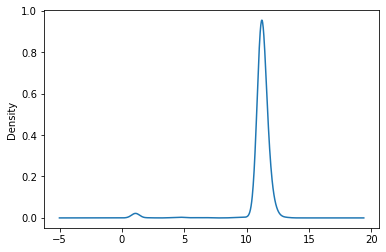

In [47]:
corr = pd.concat([X,y],axis=1).corr().pathology.sort_values(ascending=False)

In [123]:
from sklearn.linear_model import LogisticRegression
`
clf = LogisticRegression()
clf.fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test).T[1])

0.9848148148148148

LogisticRegression()

0.8035625000000001

In [51]:
cc = make_woe(X,y,cat_features)

KeyError: '225.8780059814453'

In [9]:
X_orig = X.copy()

In [10]:
X,y, X_control,y_control,_ = normalization(X.copy(),y.copy(),X_control.copy(), y_control.copy(),test_non_symm=True)

In [22]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.svm import SVC
clf = SVC(probability=True)
sfs1 = SFS(clf, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='roc_auc',
           cv=0,
           n_jobs=-1)

sfs1 = sfs1.fit(X, y)

In [62]:
X_fold, y_fold = make_folds(X,y, id_column=id_column, n=5)

In [64]:
from sklearn.model_selection import StratifiedKFold

In [65]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)

In [66]:
(folds)

StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

In [63]:
from sklearn.ensemble import RandomForestClassifier

for j in range(len(X_fold)):
    X_train, y_train = pd.concat([X_fold[k] for k in range(len(X_fold)) if k!=j]),pd.concat([y_fold[k] for k in range(len(X_fold)) if k!=j])
    X_test,y_test = X_fold[j].copy(), y_fold[j].copy()      
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train[list(sfs1.k_feature_names_)],y_train)
    print(roc_auc_score(y_train, clf.predict_proba(X_train[list(sfs1.k_feature_names_)]).T[1]))
    print(roc_auc_score(y_test, clf.predict_proba(X_test[list(sfs1.k_feature_names_)]).T[1]))
    print(roc_auc_score(y_control, clf.predict_proba(X_control[list(sfs1.k_feature_names_)]).T[1]))
    print()

1.0
1.0
0.9771180555555555

1.0
0.9864843750000001
0.9747916666666666

1.0
0.9999107142857142
0.9809722222222222

1.0
0.7728125
0.8222916666666666

1.0
0.9769097222222223
0.9769791666666666



In [44]:
roc_auc_score(y_control, clf.predict_proba(X_control[list(sfs1.k_feature_names_)]).T[1])

0.9827083333333333

In [45]:
roc_auc_score(y, clf.predict_proba(X[list(sfs1.k_feature_names_)]).T[1])

1.0

In [119]:
X=variance(X)
print(X.columns.size)
#X = outliers(X)
#print(X.columns.size)
X=correlation(X, thr = 0.95)
print(X.columns.size)

524
178


In [120]:
X = X.loc[:,X.columns]
X_control = X_control.loc[:,X.columns]

In [121]:
X_control_c = X_control.copy()

In [161]:
X.loc[:,[c for c in X.columns if c.find('f_4') != -1]]

,f_4_1_1__v1,f_4_1_2__v1,f_4_5_1__v1__(bw_1.5)__1_0,f_4_5_1__v1__(bw_1.5)__2_0,f_4_5_1__v1__(bw_2)__0_0,f_4_5_1__v1__(bw_3)__0_0,f_4_5_1__v1__(bw_3)__3_0,f_4_5_2__v1__(bw_2)__0_0__max,f_4_5_3__v1__(bw_1.5)__0_0,f_4_5_3__v1__(bw_1.5)__0_1,...,f_4_5_4__v1__(bw_1.5)__1_0,f_4_5_4__v1__(bw_1.5)__1_1,f_4_5_4__v1__(bw_1.5)__1_2,f_4_5_4__v1__(bw_1.5)__3_3,f_4_5_4__v1__(bw_2)__1_0,f_4_5_4__v1__(bw_2)__1_1,f_4_5_4__v1__(bw_2)__1_3,f_4_5_4__v1__(bw_2)__2_0,f_4_5_4__v1__(bw_2)__2_1,f_4_5_4__v1__(bw_2)__2_3
PAC_00_DN0_RAW_right,0.524362,0.456973,0.776083,0.871329,0.959693,0.073632,0.491263,0.548355,0.580399,0.347644,...,0.802195,0.640386,0.592156,0.770151,0.440175,0.402787,0.429998,0.627008,0.657682,0.595140
PAC_00_DN10_RAW_right,0.687040,0.568496,0.790941,0.806756,0.690254,0.013900,0.107050,0.772872,0.641001,0.541145,...,0.813244,0.649806,0.588606,0.746503,0.586455,0.579767,0.560264,0.574961,0.667149,0.524738
PAC_00_DN11_RAW_right,0.679916,0.508905,0.735287,0.742976,0.643317,0.012145,0.099494,0.767728,0.679345,0.597204,...,0.809462,0.668594,0.670840,0.780492,0.573512,0.697453,0.578285,0.678431,0.648454,0.597568
PAC_00_DN12_RAW_right,0.705762,0.583995,0.794646,0.827998,0.661179,0.014129,0.099392,0.785727,0.619905,0.546299,...,0.769091,0.678719,0.709944,0.785858,0.607675,0.615588,0.542074,0.701834,0.759081,0.655704
PAC_00_DN13_RAW_right,0.688899,0.594370,0.814859,0.814394,0.658738,0.014197,0.088403,0.798306,0.667737,0.511114,...,0.737867,0.595267,0.527199,0.694187,0.608843,0.710378,0.575631,0.636444,0.747961,0.637879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PAC_60_DN5_RAW_right,0.334337,0.249553,0.301382,0.258549,0.228630,0.017662,0.017848,0.882789,0.808463,0.432942,...,0.678468,0.606060,0.652305,0.680821,0.581226,0.646053,0.672234,0.650249,0.737777,0.641470
PAC_60_DN6_RAW_right,0.365136,0.257128,0.290258,0.229099,0.189487,0.020472,0.018363,0.900450,0.787466,0.464353,...,0.547196,0.410202,0.631157,0.689716,0.573121,0.483546,0.667263,0.634372,0.654254,0.513685
PAC_60_DN7_RAW_right,0.374053,0.258843,0.265024,0.187482,0.153779,0.017902,0.016044,0.917496,0.804710,0.585127,...,0.595482,0.515201,0.516565,0.657165,0.538256,0.653859,0.528431,0.691707,0.611576,0.566192
PAC_60_DN8_RAW_right,0.375500,0.263924,0.284530,0.180786,0.147586,0.016397,0.015822,0.923002,0.750256,0.687474,...,0.523921,0.546075,0.586514,0.735020,0.516901,0.582228,0.566716,0.562131,0.572165,0.547411


In [169]:
main_result = pd.DataFrame(np.zeros((5,4)),columns=['f1','sensivity','specificity','auc'])
feat_imp = []
results = []
for j in range(5):
    for i in ['f_2']:
        cols = [col for col in X.columns if col.find(i) != -1]
        #X_ = X.loc[:,cols]

        X_train, X_test, y_train, y_test = X.copy(), X_control.copy(), y.copy(), y_control.copy()

        print(X_train.shape)
        model = hp_model('lr',X_train,y_train,id_column = id_column,metric=roc_auc_score,
                        evals=50,n_folds=3,thr_diff=0.1,thr_min=0.8, print_scores=False)

        auc = roc_auc_score(y_test,model.predict(X_test))
        results.append(auc)
        print(auc)
        coefs = model.feature_importances_
        coefs = pd.Series(coefs,index=cols).sort_values(ascending=False)

        feat_imp.append(coefs)
    
    
    

(1282, 178)
100%|██████████| 50/50 [00:12<00:00,  4.07trial/s, best loss: -0.9497865013774104]
0.9625


AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [139]:
feat_imp = [f[feat_imp[0].index] for f in feat_imp]

In [143]:
coefs = sum(feat_imp)/5

In [148]:
coefs = coefs.sort_values(ascending=False)

In [153]:
coefs[-40:]

f_2_6__v1__193    0.000336
f_2_6__v1__199    0.000322
f_2_6__v1__191    0.000308
f_2_6__v1__249    0.000293
f_2_6__v1__16     0.000285
f_2_6__v1__253    0.000284
f_2_6__v1__48     0.000257
f_2_6__v1__96     0.000247
f_2_6__v1__143    0.000245
f_2_6__v1__248    0.000204
f_2_6__v1__28     0.000203
f_2_6__v1__12     0.000200
f_2_6__v1__7      0.000187
f_2_6__v1__1      0.000187
f_2_6__v1__15     0.000184
f_2_6__v1__24     0.000181
f_2_6__v1__127    0.000172
f_2_6__v1__135    0.000167
f_2_6__v1__32     0.000165
f_2_7__v1__62     0.000156
f_2_6__v1__6      0.000152
f_2_6__v1__124    0.000146
f_2_6__v1__3      0.000139
f_2_6__v1__225    0.000138
f_2_6__v1__30     0.000135
f_2_6__v1__64     0.000128
f_2_6__v1__4      0.000125
f_2_6__v1__2      0.000121
f_2_6__v1__60     0.000118
f_2_6__v1__224    0.000110
f_2_6__v1__56     0.000090
f_2_6__v1__112    0.000088
f_2_6__v1__240    0.000086
f_2_6__v1__255    0.000086
f_2_6__v1__131    0.000085
f_2_6__v1__14     0.000083
f_2_6__v1__128    0.000083
f

In [130]:
X_pca,control_pca,_,_ = pca(X,X_control)

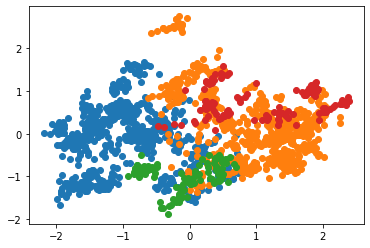

In [135]:
plt.scatter(X_pca[y==0].iloc[:,0],X_pca[y==0].iloc[:,1])
plt.scatter(X_pca[y==1].iloc[:,0],X_pca[y==1].iloc[:,1])
plt.scatter(control_pca[y_control==0].iloc[:,0],control_pca[y_control==0].iloc[:,1])
plt.scatter(control_pca[y_control==1].iloc[:,0],control_pca[y_control==1].iloc[:,1])

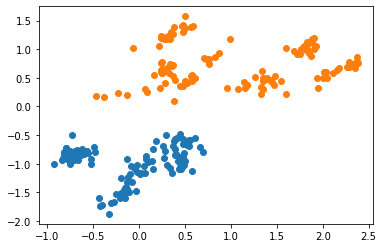

In [134]:
plt.scatter(control_pca[y_control==0].iloc[:,0],control_pca[y_control==0].iloc[:,1])
plt.scatter(control_pca[y_control==1].iloc[:,0],control_pca[y_control==1].iloc[:,1])

In [123]:
cols

['f_2_1_10__v1__(d_1_theta_all)',
 'f_2_1_12__v1__(d_1_theta_all)',
 'f_2_1_17__v1__(d_1_theta_all)',
 'f_2_1_18__v1__(d_1_theta_all)',
 'f_2_1_21__v1__(d_1_theta_all)',
 'f_2_1_3__v1__(d_1_theta_all)',
 'f_2_1_4__v1__(d_1_theta_all)',
 'f_2_1_8__v1__(d_1_theta_all)',
 'f_2_1_9__v1__(d_1_theta_all)',
 'f_2_3_10__v1',
 'f_2_3_11__v1',
 'f_2_3_2__v1',
 'f_2_3_3__v1',
 'f_2_3_4__v1',
 'f_2_3_5__v1',
 'f_2_3_9__v1',
 'f_2_4_10__v1',
 'f_2_4_1__v1',
 'f_2_4_4__v1',
 'f_2_4_7__v1',
 'f_2_4_9__v1',
 'f_2_5_1__v1',
 'f_2_5_2__v1',
 'f_2_5_3__v1',
 'f_2_5_4__v1',
 'f_2_5_5__v1',
 'f_2_6__v1__0',
 'f_2_6__v1__1',
 'f_2_6__v1__112',
 'f_2_6__v1__12',
 'f_2_6__v1__120',
 'f_2_6__v1__124',
 'f_2_6__v1__126',
 'f_2_6__v1__127',
 'f_2_6__v1__128',
 'f_2_6__v1__129',
 'f_2_6__v1__131',
 'f_2_6__v1__135',
 'f_2_6__v1__14',
 'f_2_6__v1__143',
 'f_2_6__v1__15',
 'f_2_6__v1__159',
 'f_2_6__v1__16',
 'f_2_6__v1__191',
 'f_2_6__v1__192',
 'f_2_6__v1__193',
 'f_2_6__v1__195',
 'f_2_6__v1__199',
 'f_2_6__v1__

In [98]:
cols

[]

In [73]:
cols

[]

In [71]:
cols

['f_4_5_1__v1__(bw_1.5)__1_0',
 'f_4_5_1__v1__(bw_1.5)__2_0',
 'f_4_5_1__v1__(bw_2)__0_0',
 'f_4_5_1__v1__(bw_3)__0_0',
 'f_4_5_1__v1__(bw_3)__3_0',
 'f_4_5_2__v1__(bw_2)__0_0__max',
 'f_4_5_3__v1__(bw_1.5)__0_0',
 'f_4_5_3__v1__(bw_1.5)__0_1',
 'f_4_5_3__v1__(bw_1.5)__1_0',
 'f_4_5_3__v1__(bw_1.5)__1_1',
 'f_4_5_3__v1__(bw_1.5)__2_0',
 'f_4_5_3__v1__(bw_1.5)__2_1',
 'f_4_5_3__v1__(bw_1.5)__3_0',
 'f_4_5_3__v1__(bw_1.5)__3_1',
 'f_4_5_3__v1__(bw_2)__0_0',
 'f_4_5_3__v1__(bw_2)__1_0',
 'f_4_5_3__v1__(bw_2)__1_1',
 'f_4_5_3__v1__(bw_2)__2_0',
 'f_4_5_3__v1__(bw_2)__2_1',
 'f_4_5_3__v1__(bw_3)__0_0',
 'f_4_5_3__v1__(bw_3)__3_0',
 'f_4_5_4__v1__(bw_1.5)__0_0',
 'f_4_5_4__v1__(bw_1.5)__1_0',
 'f_4_5_4__v1__(bw_1.5)__1_1',
 'f_4_5_4__v1__(bw_1.5)__1_2',
 'f_4_5_4__v1__(bw_1.5)__3_3',
 'f_4_5_4__v1__(bw_2)__1_0',
 'f_4_5_4__v1__(bw_2)__1_1',
 'f_4_5_4__v1__(bw_2)__1_3',
 'f_4_5_4__v1__(bw_2)__2_0',
 'f_4_5_4__v1__(bw_2)__2_1',
 'f_4_5_4__v1__(bw_2)__2_3']

In [63]:
auc

0.48333333333333334

In [40]:
results[2]

,f1,sensivity,specificity,auc,accuracy
lr,0.683333,0.683333,0.683333,0.683333,0.683333
svm,0.000000,0.000000,1.000000,0.500000,0.500000
rf,0.000000,0.000000,1.000000,0.500000,0.500000
xgb,0.000000,0.000000,1.000000,0.500000,0.500000
lgb,0.000000,0.000000,1.000000,0.500000,0.500000


In [31]:
coefs[0]

array([16.11824095, -5.62792993, 22.58112597, 27.59662441, 23.13922365,
        6.15908694, -3.53233895, -1.18910384, -7.43847313, -9.39800761])

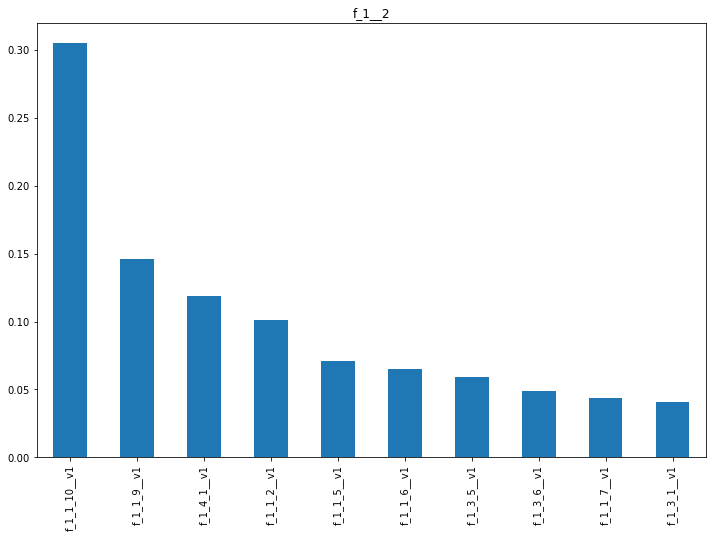

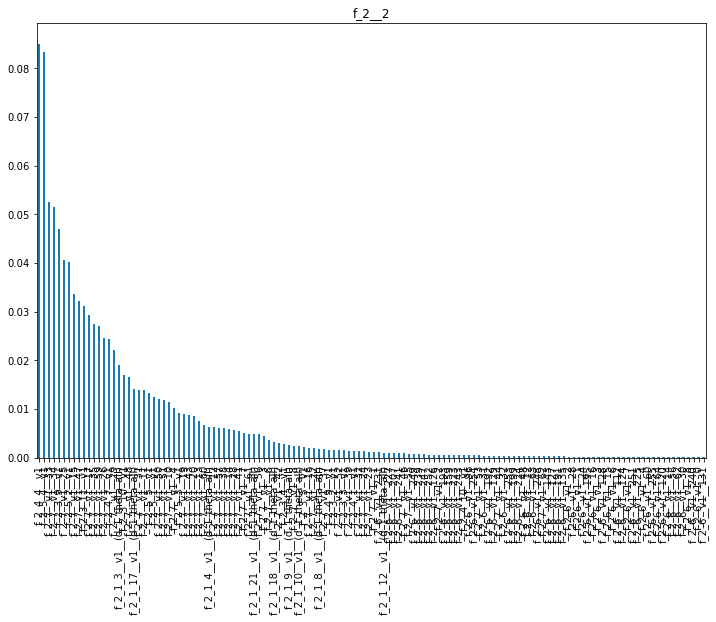

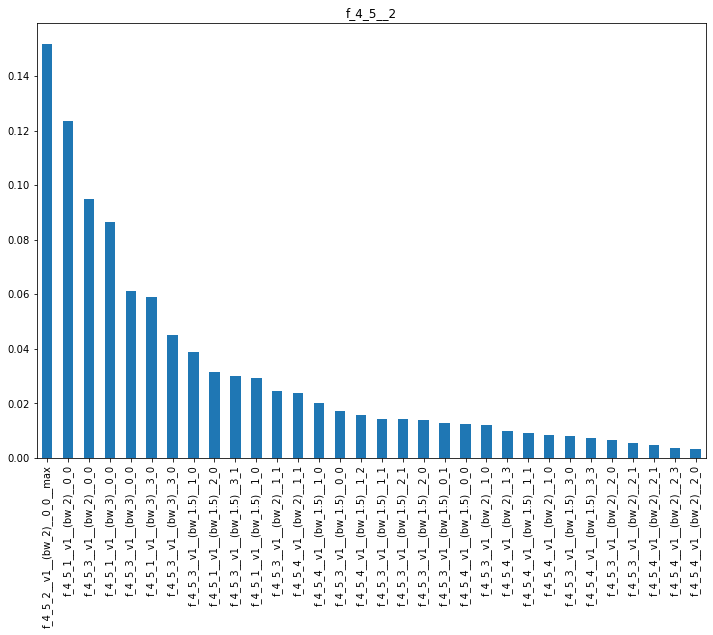

In [36]:
blocks = ['f_1','f_2','f_4_5']

feat_imp = []

for b in range(len(blocks)):
    for i in [2]:
        try:
            coefs = models[b][i].coef_[0]
        except AttributeError:
            coefs = models[b][i].feature_importances_
        cols = [col for col in X.columns if col.find(blocks[b]) != -1]
        coefs = pd.Series(coefs,index=cols).sort_values(ascending=False)
        
        feat_imp.append(coefs)
        
        plt.figure(figsize=(12,8))
        coefs.plot(kind='bar')
        plt.title(blocks[b]+'__'+str(i))
        plt.show()

In [37]:
feat_imp

[f_1_1_10__v1    0.304821
 f_1_1_9__v1     0.146122
 f_1_4_1__v1     0.118781
 f_1_1_2__v1     0.101137
 f_1_1_5__v1     0.071187
 f_1_1_6__v1     0.065294
 f_1_3_5__v1     0.058877
 f_1_3_6__v1     0.049022
 f_1_1_7__v1     0.043841
 f_1_3_1__v1     0.040918
 dtype: float64,
 f_2_4_4__v1       0.085100
 f_2_5_4__v1       0.083320
 f_2_7__v1__33     0.052435
 f_2_7__v1__34     0.051432
 f_2_3_9__v1       0.046888
                     ...   
 f_2_6__v1__30     0.000087
 f_2_6__v1__8      0.000071
 f_2_6__v1__240    0.000066
 f_2_6__v1__0      0.000041
 f_2_6__v1__131    0.000037
 Length: 134, dtype: float64,
 f_4_5_2__v1__(bw_2)__0_0__max    0.151796
 f_4_5_1__v1__(bw_2)__0_0         0.123342
 f_4_5_3__v1__(bw_2)__0_0         0.094834
 f_4_5_1__v1__(bw_3)__0_0         0.086500
 f_4_5_3__v1__(bw_3)__0_0         0.061263
 f_4_5_1__v1__(bw_3)__3_0         0.058944
 f_4_5_3__v1__(bw_3)__3_0         0.045008
 f_4_5_3__v1__(bw_1.5)__1_0       0.038792
 f_4_5_1__v1__(bw_1.5)__2_0       0.03161

In [ ]:
y_predict = pd.concat([y_predict, y],axis=1)
y_predict['id'] = id_column
y_predict.columns = ['proba','pathology','id']

In [28]:
y_predict_control = pd.concat([y_predict_control, y_control],axis=1)
y_predict_control['id'] = df_test.id
y_predict_control.columns = ['proba','pathology','id']

In [29]:
proba = y_predict.groupby('id').proba.mean()
predict = (y_predict.groupby('id').pathology.sum() > 0.).astype('int32')
result = pd.concat([predict,proba],axis=1)

In [30]:
proba_control = y_predict_control.groupby('id').proba.mean()
predict_control = (y_predict_control.groupby('id').pathology.sum() > 0.).astype('int32')
result_control = pd.concat([predict_control,proba_control],axis=1)

In [35]:
print(result.iloc[:20,:])

        pathology     proba
id                         
PAC_00          1  0.952026
PAC_01          1  0.591557
PAC_02          1  0.761126
PAC_03          1  0.904341
PAC_04          1  0.781909
PAC_05          1  0.977167
PAC_06          1  0.856273
PAC_07          1  0.939537
PAC_08          1  0.149519
PAC_09          1  1.000000
PAC_11          0  0.657000
PAC_13          0  0.118409
PAC_15          0  0.068158
PAC_16          0  0.205009
PAC_17          0  0.156426
PAC_24          1  1.000000
PAC_25          1  0.999999
PAC_26          1  0.999999
PAC_27          1  1.000000
PAC_28          1  0.991771


In [33]:
print(result_control)

        pathology     proba
id                         
PAC_14          0  0.006310
PAC_48          0  0.144259
PAC_61          1  1.000000
PAC_62          1  0.999379
PAC_63          1  0.999970
PAC_64          1  0.878731
PAC_65          1  0.998505
PAC_66          1  0.988197
PAC_69          0  0.288187
